<a href="https://colab.research.google.com/github/Pam-Pam29/Formative-2-Multimodal-Data-Preprocessing/blob/main/voice_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Voice Model  - Complete Notebook

## Overview
This notebook creates and choose the best model using audio features.csv and unknowm speaker dataset .

### What This Notebook Does:
-  Uses my existing `audio_features.csv` (Pam, Rele, Dennis)
-  Adds unknown speaker detection
-  Trains improved 4-class model
-  Comprehensive EDA with visualizations

### Key Features:
1. **Exploratory Data Analysis (EDA)**
   - Data distribution analysis
   - Feature correlation matrices
   - Outlier detection and visualization
   - Class balance analysis

2. **Model Improvement**
   - Unknown speaker integration
   - Audio augmentation
   - Hyperparameter tuning
   - Probability calibration

3. **Evaluation**
   - Performance metrics
   - Confusion matrices
   - Unknown speaker detection analysis


##  Step 1: Install and Import Libraries

First, I imported all necessary libraries for data processing, machine learning, and visualization.


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
import os
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, log_loss
)
import joblib
import warnings
warnings.filterwarnings('ignore')

try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("  imbalanced-learn not installed. Install with: pip install imbalanced-learn")

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("  XGBoost not installed. Install with: pip install xgboost")

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" All libraries imported successfully!")


 All libraries imported successfully!


##  Step 2: Load Existing Data

Loaded my existing `audio_features.csv` file containing features for Pam, Rele, and Dennis.


In [106]:
print("\n" + "="*80)
print("STEP 2: LOADING EXISTING DATA")
print("="*80)

try:

    df_existing = pd.read_csv('audio_features.csv')
    print(f" Loaded audio_features.csv: {len(df_existing)} samples")
except FileNotFoundError:
    csv_url = 'https://raw.githubusercontent.com/Pam-Pam29/Formative-2-Multimodal-Data-Preprocessing/refs/heads/main/audio_features%20.csv'
    print(f"  Local file not found. Loading from GitHub...")
    df_existing = pd.read_csv(csv_url)
    print(f" Loaded from GitHub: {len(df_existing)} samples")

print(f"\n Existing Data Summary:")
print(f"   Total samples: {len(df_existing)}")
print(f"   Speakers: {df_existing['speaker'].unique()}")
print(f"\n   Speaker distribution:")
print(df_existing['speaker'].value_counts())

print(f"\n First 5 rows:")
display(df_existing.head())



STEP 2: LOADING EXISTING DATA
  Local file not found. Loading from GitHub...
 Loaded from GitHub: 54 samples

 Existing Data Summary:
   Total samples: 54
   Speakers: ['Pam' 'Rele' 'dennis']

   Speaker distribution:
speaker
Pam       18
Rele      18
dennis    18
Name: count, dtype: int64

 First 5 rows:


,file_id,speaker,audio_name,augmentation,audio_path,mfcc_mean_0,mfcc_std_0,mfcc_max_0,mfcc_min_0,mfcc_mean_1,...,chroma_mean_9,chroma_std_9,chroma_mean_10,chroma_std_10,chroma_mean_11,chroma_std_11,duration,sample_rate,max_amplitude,mean_amplitude
0,1,Pam,Pam_Confirm transaction,original,audio_files/Pam_Confirm transaction.wav,-354.71155,125.916405,-164.26454,-589.04340,86.001490,...,0.452131,0.278201,0.397025,0.291749,0.370353,0.305417,2.645333,48000,0.563415,0.043544
1,1,Pam,Pam_Confirm transaction,pitch_shift_up,audio_files/Pam_Confirm transaction.wav,-383.71915,126.196014,-201.16850,-608.92520,74.938770,...,0.436571,0.343078,0.457633,0.323268,0.417882,0.301396,2.645333,48000,0.523071,0.030442
2,1,Pam,Pam_Confirm transaction,pitch_shift_down,audio_files/Pam_Confirm transaction.wav,-396.58200,125.010574,-212.77580,-631.03436,91.131714,...,0.378569,0.306704,0.401508,0.345998,0.413870,0.366689,2.645333,48000,0.398560,0.028268
3,1,Pam,Pam_Confirm transaction,time_stretch_slow,audio_files/Pam_Confirm transaction.wav,-385.41556,123.019516,-208.29646,-602.77100,80.274430,...,0.527957,0.284170,0.454401,0.271440,0.418228,0.318869,2.939250,48000,0.378479,0.031639
4,1,Pam,Pam_Confirm transaction,time_stretch_fast,audio_files/Pam_Confirm transaction.wav,-385.83115,125.387180,-206.73343,-616.22560,83.641480,...,0.433550,0.268575,0.377162,0.308262,0.329577,0.280080,2.404854,48000,0.372681,0.030970


##  Step 3: Exploratory Data Analysis (EDA)

This is so i could understand the data structure, distributions, correlations, and identify any outliers.


In [105]:
print("\n" + "="*80)
print("STEP 3: EXPLORATORY DATA ANALYSIS")
print("="*80)

print("\n Dataset Information:")
print(f"   Shape: {df_existing.shape}")
print(f"   Columns: {len(df_existing.columns)}")
print(f"   Missing values: {df_existing.isnull().sum().sum()}")

exclude_cols = ['file_id', 'speaker', 'audio_name', 'augmentation', 'audio_path']
feature_cols = [col for col in df_existing.columns if col not in exclude_cols]
print(f"   Feature columns: {len(feature_cols)}")


print("\n Basic Statistics:")
display(df_existing[feature_cols].describe())



STEP 3: EXPLORATORY DATA ANALYSIS

 Dataset Information:
   Shape: (54, 96)
   Columns: 96
   Missing values: 0
   Feature columns: 91

 Basic Statistics:


,mfcc_mean_0,mfcc_std_0,mfcc_max_0,mfcc_min_0,mfcc_mean_1,mfcc_std_1,mfcc_max_1,mfcc_min_1,mfcc_mean_2,mfcc_std_2,...,chroma_mean_9,chroma_std_9,chroma_mean_10,chroma_std_10,chroma_mean_11,chroma_std_11,duration,sample_rate,max_amplitude,mean_amplitude
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.0,54.000000,54.000000
mean,-416.766271,97.357339,-226.931872,-600.572837,84.233455,45.213893,188.255964,-12.543054,14.636513,29.974634,...,0.515099,0.268370,0.509664,0.287220,0.501704,0.292195,2.384980,48000.0,0.401561,0.026549
std,104.518172,29.950701,89.277426,137.973199,32.548824,9.074689,41.037841,17.488107,6.985217,7.176831,...,0.107570,0.037204,0.101000,0.041701,0.095020,0.036846,0.581310,0.0,0.265694,0.017312
min,-578.975950,16.452490,-391.207950,-796.523300,7.419573,18.943575,75.396350,-50.823166,2.032974,12.867765,...,0.316760,0.164226,0.337000,0.187548,0.328468,0.221258,1.446958,48000.0,0.048798,0.003730
25%,-511.484400,82.383242,-295.545975,-718.938072,71.489147,38.970020,153.582510,-23.607839,9.293616,25.216356,...,0.434305,0.237240,0.449139,0.263830,0.421414,0.270130,1.982667,48000.0,0.098206,0.007512
50%,-400.238700,104.632350,-208.416830,-616.540450,90.135452,44.383705,203.222945,-9.261309,13.888413,29.169493,...,0.501547,0.275243,0.497219,0.296102,0.507445,0.288426,2.302146,48000.0,0.412109,0.027518
75%,-359.200350,122.603219,-164.593990,-554.143455,108.481105,53.549670,218.904355,0.000000,17.496333,35.430073,...,0.584449,0.296529,0.577925,0.313681,0.561976,0.318752,2.645333,48000.0,0.568321,0.040596
max,-221.941130,131.254680,-87.501840,-319.178740,130.237690,58.402160,242.907150,17.638240,33.708416,45.747040,...,0.782838,0.343078,0.731182,0.357150,0.718616,0.401365,3.938833,48000.0,0.947479,0.066025


### 3.1 Class Distribution Visualization


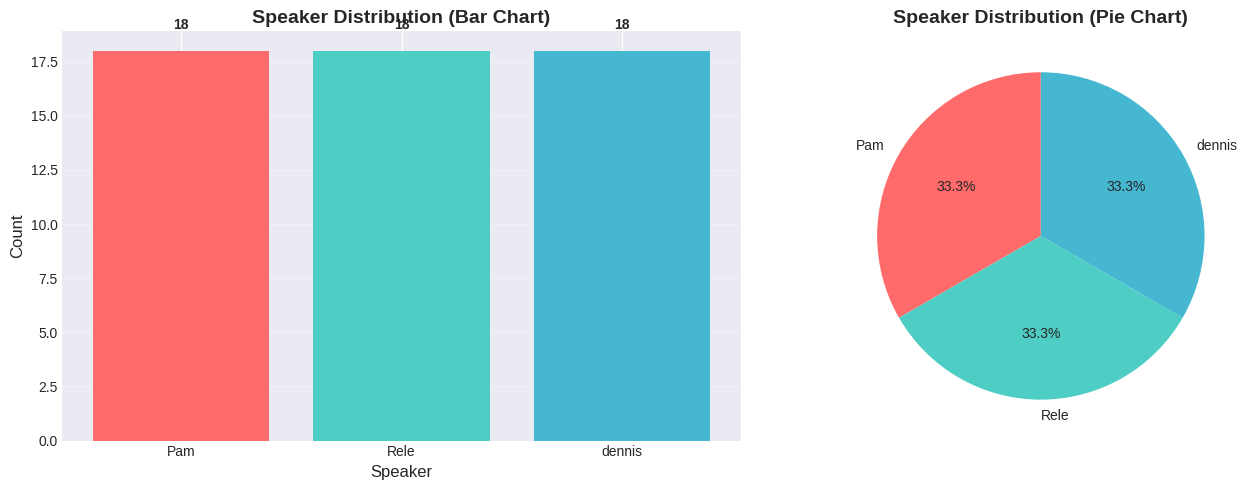


 Class Balance:
   Pam: 18 samples (33.3%)
   Rele: 18 samples (33.3%)
   dennis: 18 samples (33.3%)


In [104]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

speaker_counts = df_existing['speaker'].value_counts()
axes[0].bar(speaker_counts.index, speaker_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0].set_title('Speaker Distribution (Bar Chart)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Speaker', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(speaker_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')


axes[1].pie(speaker_counts.values, labels=speaker_counts.index, autopct='%1.1f%%',
            colors=['#FF6B6B', '#4ECDC4', '#45B7D1'], startangle=90)
axes[1].set_title('Speaker Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n Class Balance:")
for speaker, count in speaker_counts.items():
    percentage = (count / len(df_existing)) * 100
    print(f"   {speaker}: {count} samples ({percentage:.1f}%)")


### 3.2 Feature Distribution Analysis


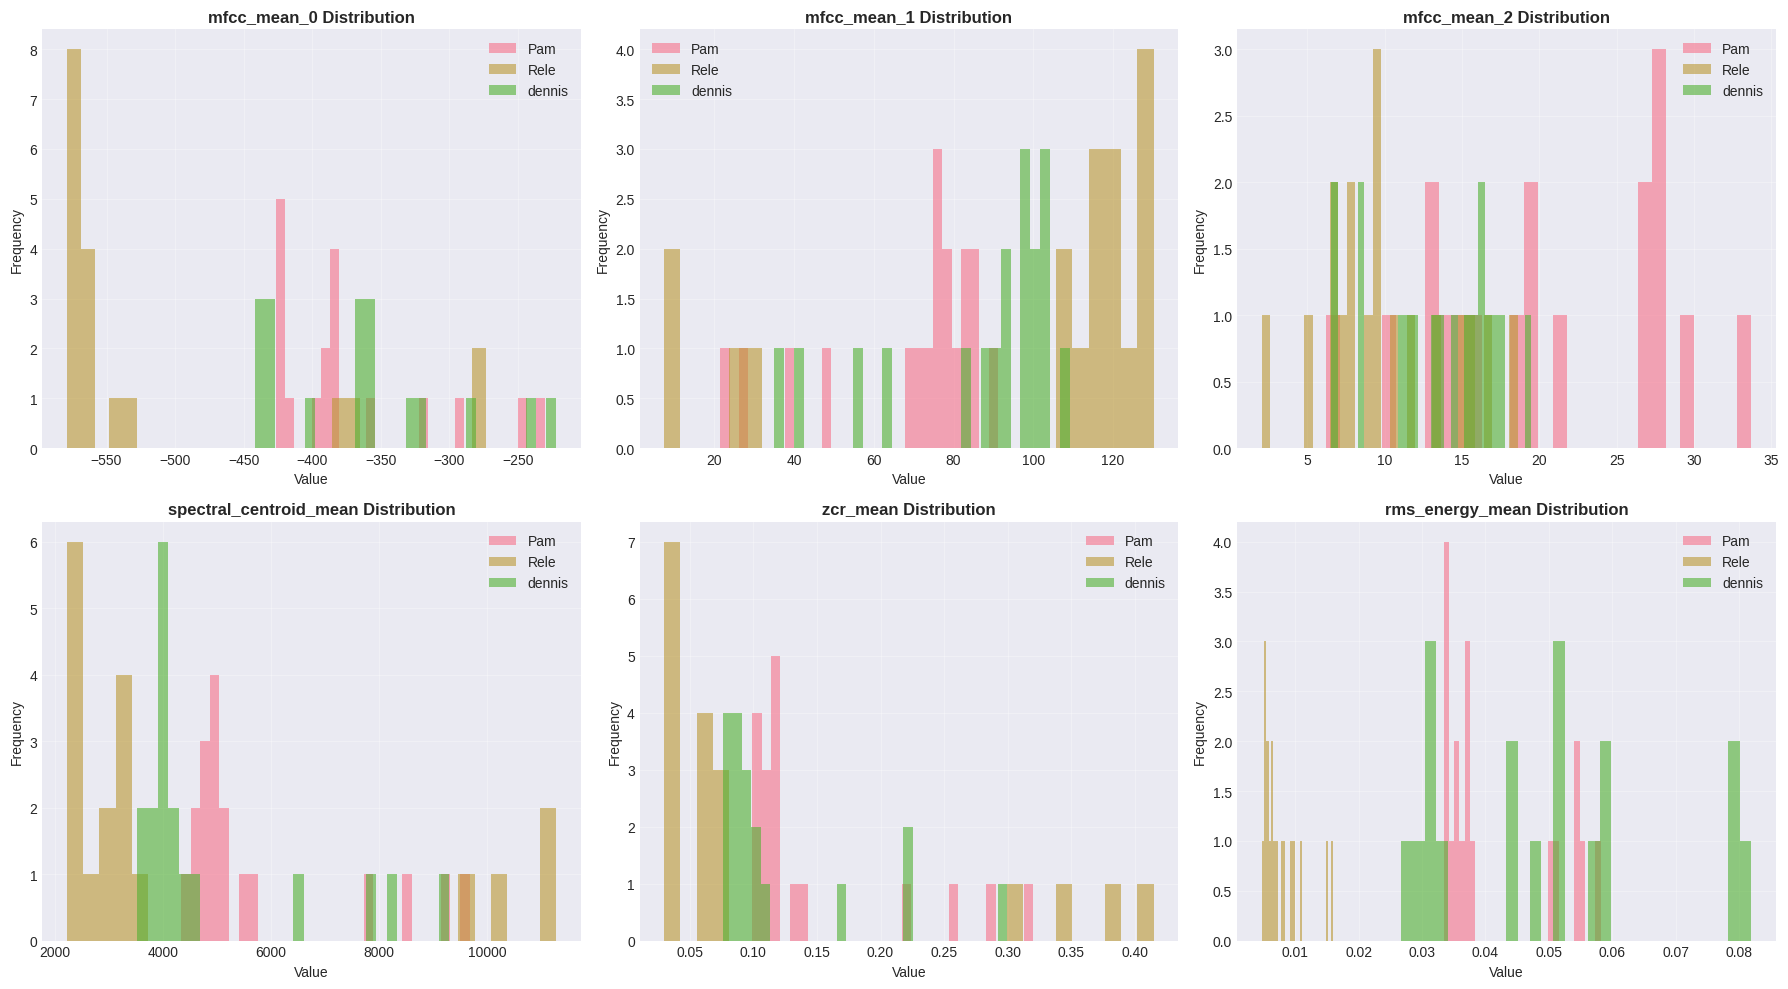

In [103]:
key_features = ['mfcc_mean_0', 'mfcc_mean_1', 'mfcc_mean_2',
                'spectral_centroid_mean', 'zcr_mean', 'rms_energy_mean']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    if feature in df_existing.columns:
        for speaker in df_existing['speaker'].unique():
            data = df_existing[df_existing['speaker'] == speaker][feature]
            axes[idx].hist(data, alpha=0.6, label=speaker, bins=30)
        axes[idx].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Value', fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 3.3 Correlation Matrix


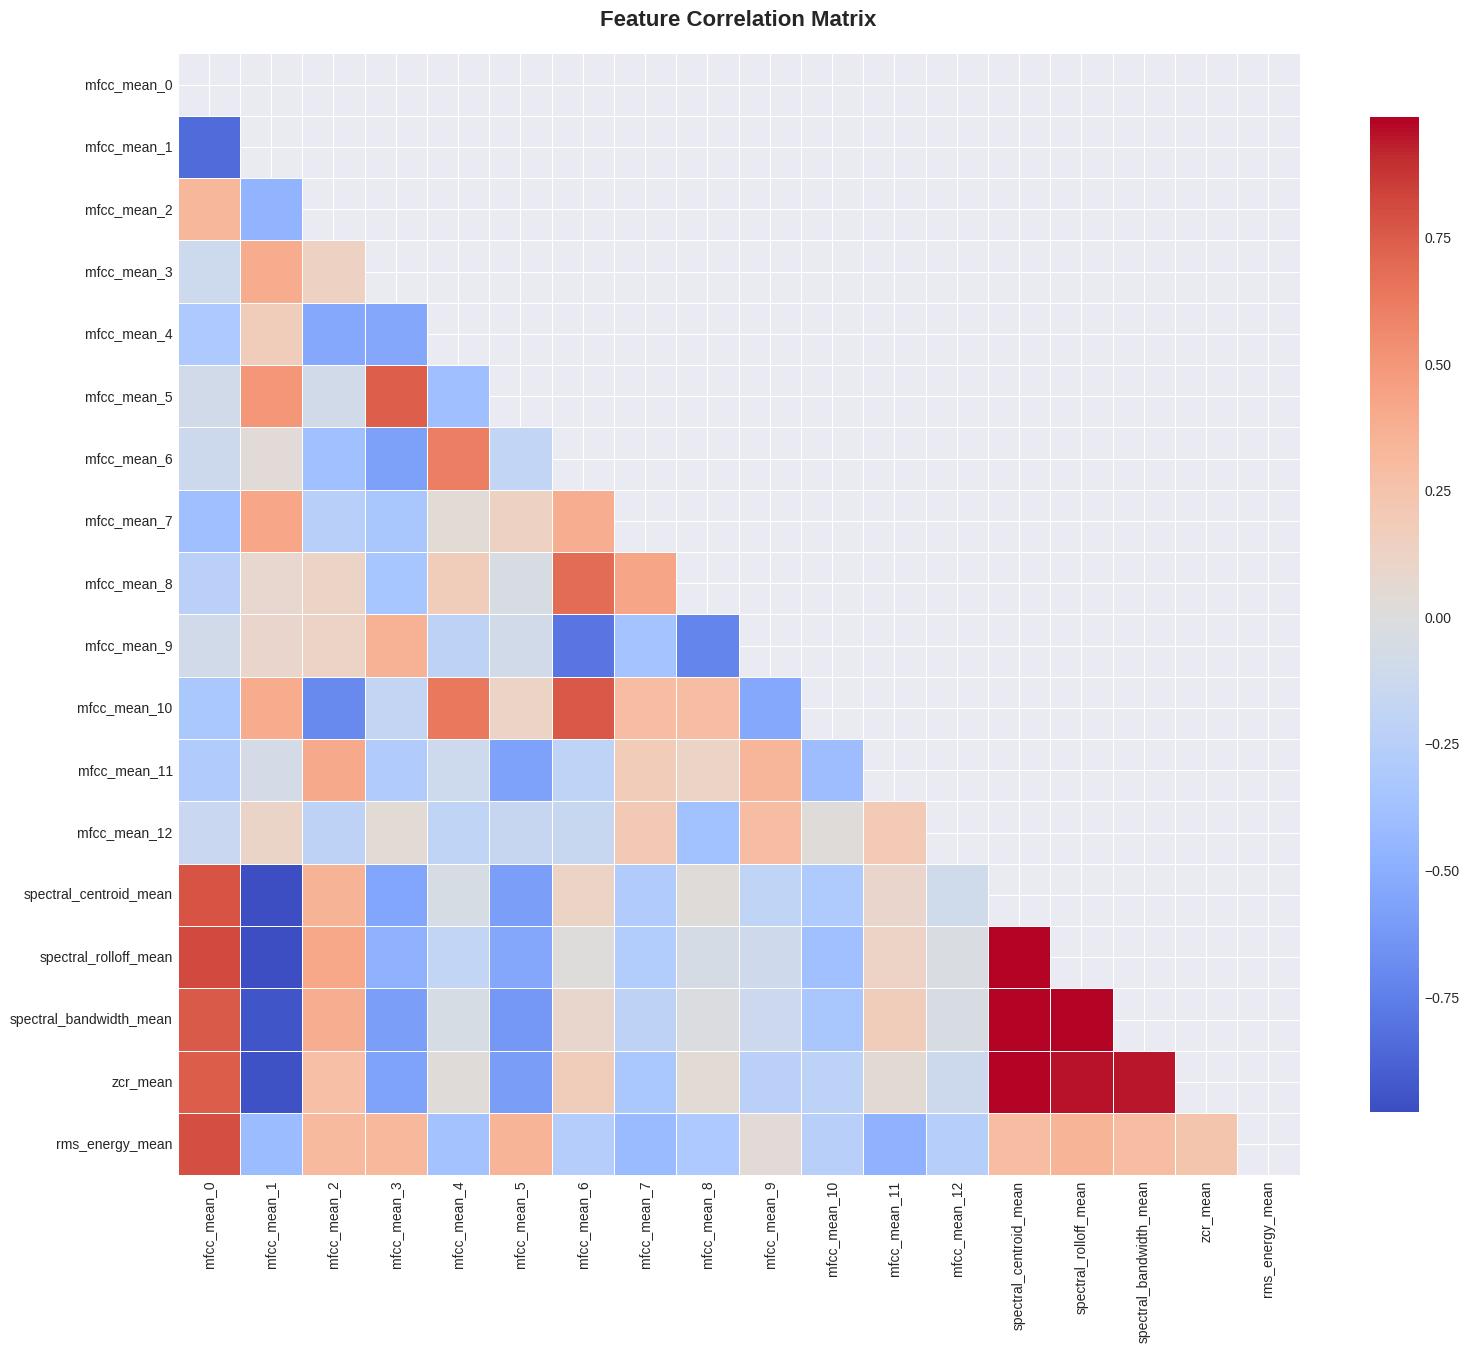


  Found 12 highly correlated feature pairs (|r| > 0.8):
   mfcc_mean_0 <-> mfcc_mean_1: -0.844
   mfcc_mean_0 <-> spectral_rolloff_mean: 0.815
   mfcc_mean_1 <-> spectral_centroid_mean: -0.976
   mfcc_mean_1 <-> spectral_rolloff_mean: -0.978
   mfcc_mean_1 <-> spectral_bandwidth_mean: -0.947
   mfcc_mean_1 <-> zcr_mean: -0.958
   spectral_centroid_mean <-> spectral_rolloff_mean: 0.986
   spectral_centroid_mean <-> spectral_bandwidth_mean: 0.979
   spectral_centroid_mean <-> zcr_mean: 0.989
   spectral_rolloff_mean <-> spectral_bandwidth_mean: 0.982


In [102]:
correlation_features = [f'mfcc_mean_{i}' for i in range(13)] + \
                      ['spectral_centroid_mean', 'spectral_rolloff_mean',
                       'spectral_bandwidth_mean', 'zcr_mean', 'rms_energy_mean']
correlation_features = [f for f in correlation_features if f in df_existing.columns]

corr_matrix = df_existing[correlation_features].corr()

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"\n  Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.8):")
    for feat1, feat2, corr in high_corr_pairs[:10]:  # Show first 10
        print(f"   {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\n No highly correlated features found (all |r| < 0.8)")


### 3.4 Outlier Detection


In [101]:
def detect_outliers_iqr(df, feature_cols):
    """Detect outliers using Interquartile Range method"""
    outlier_info = {}

    for col in feature_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_info[col] = {
                'count': len(outliers),
                'percentage': (len(outliers) / len(df)) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

    return outlier_info

outlier_info = detect_outliers_iqr(df_existing, feature_cols)


total_outliers = sum([info['count'] for info in outlier_info.values()])
print(f"\n Outlier Detection Summary:")
print(f"   Total outlier instances: {total_outliers}")
print(f"   Features with outliers: {sum([1 for info in outlier_info.values() if info['count'] > 0])}")

outlier_summary = sorted([(col, info['count'], info['percentage'])
                          for col, info in outlier_info.items()
                          if info['count'] > 0],
                         key=lambda x: x[1], reverse=True)

if outlier_summary:
    print(f"\n   Top 10 features with most outliers:")
    for col, count, pct in outlier_summary[:10]:
        print(f"      {col}: {count} outliers ({pct:.1f}%)")



 Outlier Detection Summary:
   Total outlier instances: 107
   Features with outliers: 32

   Top 10 features with most outliers:
      spectral_centroid_std: 15 outliers (27.8%)
      zcr_mean: 11 outliers (20.4%)
      spectral_centroid_mean: 9 outliers (16.7%)
      mfcc_max_3: 7 outliers (13.0%)
      mfcc_mean_11: 6 outliers (11.1%)
      mfcc_max_12: 6 outliers (11.1%)
      mfcc_std_4: 4 outliers (7.4%)
      mfcc_max_9: 4 outliers (7.4%)
      spectral_bandwidth_mean: 4 outliers (7.4%)
      mfcc_mean_8: 3 outliers (5.6%)


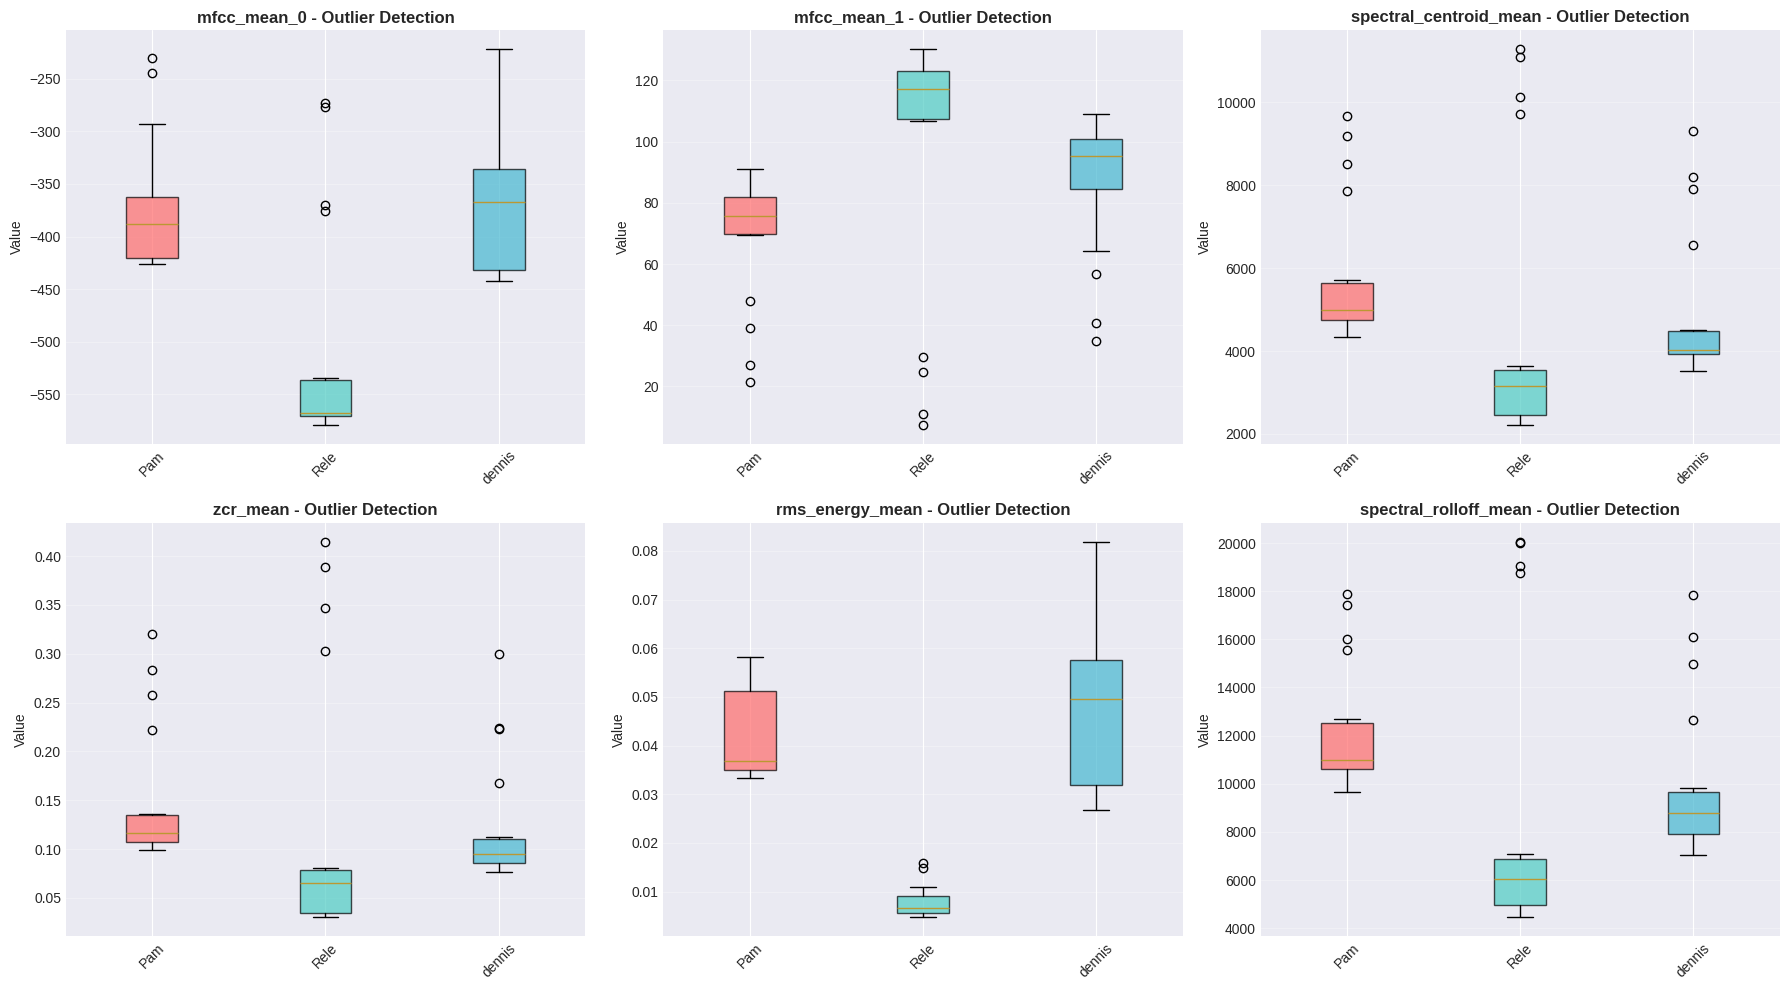


 Box plots show outliers as points beyond the whiskers (1.5 * IQR)


In [99]:
key_features_viz = ['mfcc_mean_0', 'mfcc_mean_1', 'spectral_centroid_mean',
                    'zcr_mean', 'rms_energy_mean', 'spectral_rolloff_mean']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features_viz):
    if feature in df_existing.columns:
        data_to_plot = [df_existing[df_existing['speaker'] == speaker][feature].values
                       for speaker in df_existing['speaker'].unique()]

        bp = axes[idx].boxplot(data_to_plot, labels=df_existing['speaker'].unique(),
                              patch_artist=True)

        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        axes[idx].set_title(f'{feature} - Outlier Detection', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Value', fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n Box plots show outliers as points beyond the whiskers (1.5 * IQR)")


### 3.5 Feature Importance Preview (by Speaker Separation)



 Top 10 Features for Speaker Separation (F-statistic):
----------------------------------------------------------------------
 1. mfcc_max_0                     | F-stat:    66.50 | p-value: 6.16e-15
 2. mfcc_mean_4                    | F-stat:    58.68 | p-value: 5.95e-14
 3. mfcc_std_1                     | F-stat:    43.84 | p-value: 8.35e-12
 4. mfcc_min_1                     | F-stat:    35.85 | p-value: 1.90e-10
 5. mfcc_max_4                     | F-stat:    23.53 | p-value: 5.76e-08
 6. mfcc_mean_0                    | F-stat:    18.74 | p-value: 7.92e-07
 7. mfcc_std_3                     | F-stat:    16.22 | p-value: 3.53e-06
 8. mfcc_mean_2                    | F-stat:    16.10 | p-value: 3.81e-06
 9. mfcc_max_3                     | F-stat:    14.65 | p-value: 9.39e-06
10. mfcc_max_1                     | F-stat:     8.71 | p-value: 5.55e-04


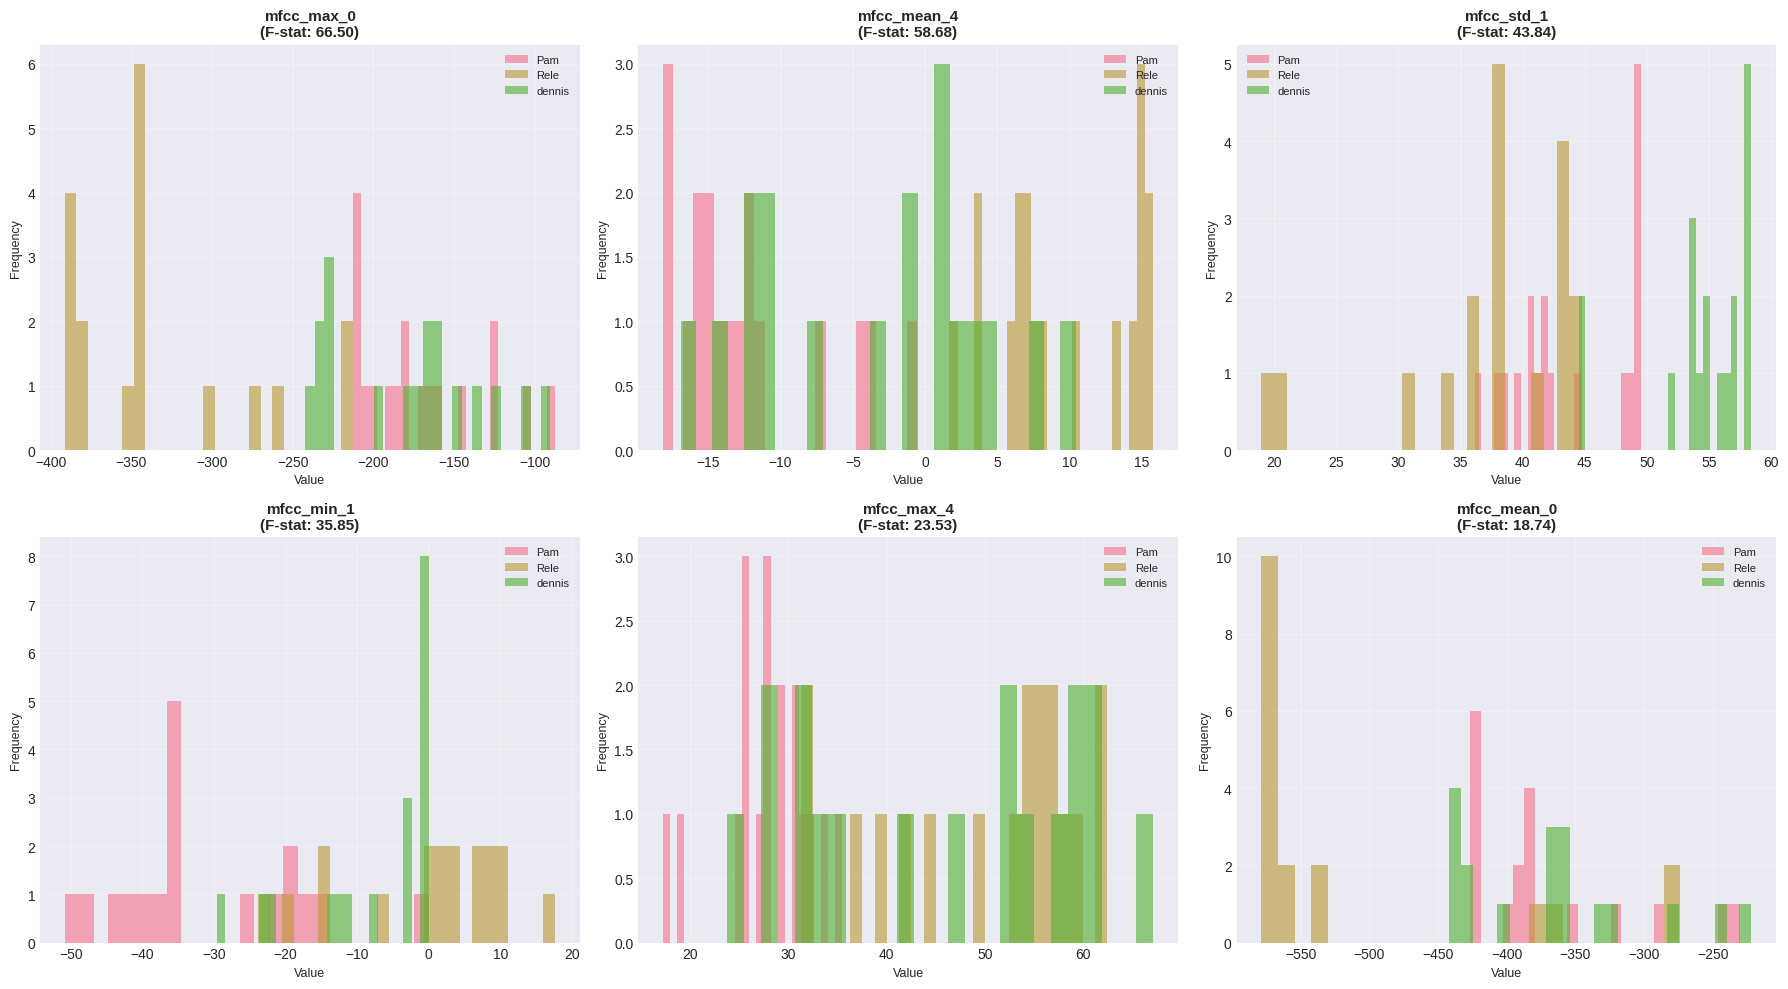

In [100]:
from scipy import stats

feature_separation = {}
for col in feature_cols[:20]:
    if col in df_existing.columns:
        groups = [df_existing[df_existing['speaker'] == speaker][col].values
                 for speaker in df_existing['speaker'].unique()]

        f_stat, p_value = stats.f_oneway(*groups)
        feature_separation[col] = {'f_stat': f_stat, 'p_value': p_value}

sorted_features = sorted(feature_separation.items(),
                        key=lambda x: x[1]['f_stat'],
                        reverse=True)

print("\n Top 10 Features for Speaker Separation (F-statistic):")
print("-" * 70)
for i, (feature, stats) in enumerate(sorted_features[:10], 1):
    print(f"{i:2d}. {feature:30s} | F-stat: {stats['f_stat']:8.2f} | p-value: {stats['p_value']:.2e}")

top_features = [f[0] for f in sorted_features[:6]]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    if feature in df_existing.columns:
        for speaker in df_existing['speaker'].unique():
            data = df_existing[df_existing['speaker'] == speaker][feature]
            axes[idx].hist(data, alpha=0.6, label=speaker, bins=25)
        axes[idx].set_title(f'{feature}\n(F-stat: {feature_separation[feature]["f_stat"]:.2f})',
                           fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Value', fontsize=9)
        axes[idx].set_ylabel('Frequency', fontsize=9)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()


##  Step 4: Feature Extraction Functions

Define functions to extract audio features from unknown speaker files. These functions were used in my existing dataset.


In [98]:
print("\n" + "="*80)
print("STEP 4: DEFINING FEATURE EXTRACTION FUNCTIONS")
print("="*80)

def extract_all_audio_features(audio_path):
    """
    Extract comprehensive audio features from a single file
    IMPORTANT: This extracts the SAME features as your existing data
    """
    try:
        audio, sr = librosa.load(audio_path, sr=22050, duration=5.0)

        features = {}


        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        for i in range(13):
            features[f'mfcc_mean_{i}'] = np.mean(mfccs[i])
            features[f'mfcc_std_{i}'] = np.std(mfccs[i])
            features[f'mfcc_max_{i}'] = np.max(mfccs[i])
            features[f'mfcc_min_{i}'] = np.min(mfccs[i])

        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
        features['spectral_centroid_mean'] = np.mean(spectral_centroid)
        features['spectral_centroid_std'] = np.std(spectral_centroid)

        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_std'] = np.std(spectral_rolloff)

        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)


        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        for i in range(12):
            features[f'chroma_mean_{i}'] = np.mean(chroma[i])
            features[f'chroma_std_{i}'] = np.std(chroma[i])


        zcr = librosa.feature.zero_crossing_rate(audio)
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)


        rms = librosa.feature.rms(y=audio)
        features['rms_energy_mean'] = np.mean(rms)
        features['rms_energy_std'] = np.std(rms)
        features['rms_energy_max'] = np.max(rms)


        features['duration'] = len(audio) / sr
        features['sample_rate'] = sr
        features['max_amplitude'] = np.max(np.abs(audio))
        features['mean_amplitude'] = np.mean(np.abs(audio))

        return features

    except Exception as e:
        print(f"   Error extracting features: {e}")
        return None

def augment_audio(audio, sr):
    """Apply audio augmentations to increase training diversity"""
    augmented = {}


    augmented['original'] = audio


    noise = np.random.normal(0, 0.003, len(audio))
    augmented['noise_low'] = audio + noise


    noise = np.random.normal(0, 0.01, len(audio))
    augmented['noise_high'] = audio + noise


    augmented['speed_0.9'] = librosa.effects.time_stretch(audio, rate=0.9)
    augmented['speed_1.1'] = librosa.effects.time_stretch(audio, rate=1.1)


    augmented['pitch_shift_down'] = librosa.effects.pitch_shift(audio, sr=sr, n_steps=-2)
    augmented['pitch_shift_up'] = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)


    augmented['volume_0.8'] = audio * 0.8

    return augmented

print(" Feature extraction functions defined!")



STEP 4: DEFINING FEATURE EXTRACTION FUNCTIONS
 Feature extraction functions defined!


##  Step 5: Clone GitHub Repository and Configure Unknown Speaker Files
I cloned the GitHub repository so that the notebook will automatically find audio files in:
- `Formative-2-Multimodal-Data-Preprocessing/data/audio_samples/unknown_speakers/`

**Supported formats:** `.flac`, `.wav`, `.mp3`, `.m4a`, `.ogg`

The code will automatically find all audio files in this directory. There are 12 audio files from different speakers (not Pam, Rele, or Dennis).


### Clone GitHub Repository (If Needed)



In [97]:
import subprocess

repo_url = 'https://github.com/Pam-Pam29/Formative-2-Multimodal-Data-Preprocessing.git'
repo_name = 'Formative-2-Multimodal-Data-Preprocessing'

if not os.path.exists(repo_name):
    print(f" Cloning repository from GitHub...")
    try:
        subprocess.run(['git', 'clone', repo_url], check=True)
        print(f" Repository cloned successfully!")
        print(f"   Location: {os.path.abspath(repo_name)}")
    except subprocess.CalledProcessError as e:
        print(f" Error cloning repository: {e}")
        print(f"   Make sure git is installed and the repository URL is correct")
    except FileNotFoundError:
        print(f" Git not found. Please install git or clone the repository manually")
        print(f"   You can clone it manually with: git clone {repo_url}")
else:
    print(f" Repository already exists: {os.path.abspath(repo_name)}")


 Repository already exists: /content/Formative-2-Multimodal-Data-Preprocessing


In [108]:
print("\n" + "="*80)
print("STEP 5: CONFIGURE UNKNOWN SPEAKER FILES")
print("="*80)

current_dir = os.getcwd()
print(f" Current working directory: {current_dir}")

possible_paths = [
    'Formative-2-Multimodal-Data-Preprocessing/data/audio_samples/unknown_speakers',
    './Formative-2-Multimodal-Data-Preprocessing/data/audio_samples/unknown_speakers',
    '../Formative-2-Multimodal-Data-Preprocessing/data/audio_samples/unknown_speakers',
    '../../Formative-2-Multimodal-Data-Preprocessing/data/audio_samples/unknown_speakers',

    os.path.join(current_dir, 'Formative-2-Multimodal-Data-Preprocessing/data/audio_samples/unknown_speakers'),
]

unknown_speaker_files = []

found_dir = None
print(f"\n Searching for unknown_speakers directory...")
for path in possible_paths:
    abs_path = os.path.abspath(path)
    if os.path.exists(path) and os.path.isdir(path):
        found_dir = path
        print(f" Found unknown speakers directory: {abs_path}")
        break
    else:
        pass

if found_dir:
    audio_extensions = ['.flac', '.wav', '.mp3', '.m4a', '.ogg']

    print(f"\n Searching for audio files in: {os.path.abspath(found_dir)}")

    for ext in audio_extensions:
        pattern_lower = f'*{ext}'
        pattern_upper = f'*{ext.upper()}'

        try:
            files_lower = list(Path(found_dir).glob(pattern_lower))
            files_upper = list(Path(found_dir).glob(pattern_upper))
            all_files = files_lower + files_upper
            unknown_speaker_files.extend([str(f) for f in all_files])
        except Exception as e:
            print(f"     Error searching for {ext} files: {e}")

    if len(unknown_speaker_files) == 0:
        try:
            all_files_in_dir = os.listdir(found_dir)
            for filename in all_files_in_dir:
                file_path = os.path.join(found_dir, filename)
                if os.path.isfile(file_path):
                    ext = Path(filename).suffix.lower()
                    if ext in audio_extensions:
                        unknown_speaker_files.append(file_path)
        except Exception as e:
            print(f"     Error listing directory: {e}")

    unknown_speaker_files = sorted(list(set(unknown_speaker_files)))

    print(f"\n Found {len(unknown_speaker_files)} audio files in directory")

    if len(unknown_speaker_files) > 0:
        print(f"\n   File types found:")
        file_types = {}
        for f in unknown_speaker_files:
            ext = Path(f).suffix.lower()
            file_types[ext] = file_types.get(ext, 0) + 1
        for ext, count in file_types.items():
            print(f"      {ext}: {count} files")

        print(f"\n   First 10 files:")
        for idx, f in enumerate(unknown_speaker_files[:10], 1):
            print(f"      {idx}. {os.path.basename(f)}")
        if len(unknown_speaker_files) > 10:
            print(f"      ... and {len(unknown_speaker_files) - 10} more files")
    else:
        print(f"\n  No audio files found in {found_dir}")
        print(f"   Supported formats: {', '.join(audio_extensions)}")
else:
    print(f"\n  Unknown speakers directory not found!")
    print(f"\n   Searched in the following locations:")
    for i, path in enumerate(possible_paths[:10], 1):
        abs_path = os.path.abspath(path)
        exists = "" if os.path.exists(path) else ""
        print(f"      {i}. {exists} {abs_path}")

    print(f"\n    Checking for GitHub repository structure...")
    repo_paths_to_check = [
        'Formative-2-Multimodal-Data-Preprocessing',
        './Formative-2-Multimodal-Data-Preprocessing',
        '../Formative-2-Multimodal-Data-Preprocessing',
    ]

    repo_found = False
    for repo_path in repo_paths_to_check:
        if os.path.exists(repo_path) and os.path.isdir(repo_path):
            print(f"    Found repository directory: {os.path.abspath(repo_path)}")
            data_path = os.path.join(repo_path, 'data/audio_samples/unknown_speakers')
            if os.path.exists(data_path):
                found_dir = data_path
                print(f"    Found unknown_speakers directory: {os.path.abspath(found_dir)}")
                repo_found = True
                break
            else:
                print(f"     Repository found, but data/audio_samples/unknown_speakers not found")
                print(f"      Checked: {os.path.abspath(data_path)}")

    if not repo_found:
        unknown_speaker_files = []
        print(f"\n     No directory found. Please:")
        print(f"      1. Run the cell above to clone the GitHub repository")
        print(f"      2. Or make sure the repository is cloned in the current directory")
        print(f"      3. Check that the directory structure is correct:")
        print(f"         Formative-2-Multimodal-Data-Preprocessing/data/audio_samples/unknown_speakers/")
        print(f"      4. Check the current working directory shown above")

print(f"\n Total unknown speaker files: {len(unknown_speaker_files)}")

if len(unknown_speaker_files) == 0:
    print("\n" + ""*40)
    print("  WARNING: NO UNKNOWN SPEAKER FILES FOUND!")
    print(""*40)
    print("""
    To enable unknown speaker detection, you need audio files in:
    Formative-2-Multimodal-Data-Preprocessing/data/audio_samples/unknown_speakers/

    Supported formats: .flac, .wav, .mp3, .m4a, .ogg

    For now, the notebook will continue with 3-class training (no unknown detection).
    """)

    try:
        proceed = input("\nContinue with 3-class model only? (yes/no): ").strip().lower()
        if proceed not in ['yes', 'y']:
            print("Notebook stopped. Please add unknown speaker files and re-run.")
            raise SystemExit
    except:
        print("\n  Continuing with 3-class model (no unknown detection)")
else:
    missing_files = [f for f in unknown_speaker_files if not os.path.exists(f)]
    if missing_files:
        print(f"\n ERROR: {len(missing_files)} files not found:")
        for f in missing_files[:5]:
            print(f"   - {f}")
        if len(missing_files) > 5:
            print(f"   ... and {len(missing_files)-5} more")
        raise FileNotFoundError("Please check file paths")

    print("\n All unknown speaker files verified!")
    print(f"   Ready to process {len(unknown_speaker_files)} files")



STEP 5: CONFIGURE UNKNOWN SPEAKER FILES
 Current working directory: /content

 Searching for unknown_speakers directory...
 Found unknown speakers directory: /content/Formative-2-Multimodal-Data-Preprocessing/data/audio_samples/unknown_speakers

 Searching for audio files in: /content/Formative-2-Multimodal-Data-Preprocessing/data/audio_samples/unknown_speakers

 Found 12 audio files in directory

   File types found:
      .flac: 12 files

   First 10 files:
      1. 84-121550-0024.flac
      2. 84-121550-0025.flac
      3. 84-121550-0026.flac
      4. 84-121550-0027.flac
      5. 84-121550-0028.flac
      6. 84-121550-0029.flac
      7. 84-121550-0030.flac
      8. 84-121550-0031.flac
      9. 84-121550-0032.flac
      10. 84-121550-0033.flac
      ... and 2 more files

 Total unknown speaker files: 12

 All unknown speaker files verified!
   Ready to process 12 files


##  Step 6: Process Unknown Speakers

I am Processing unknown speaker audio files and extracting features with augmentation.


In [109]:
def process_unknown_speakers(audio_files_list, output_csv='unknown_features.csv'):
    """
    Process unknown speaker audio files and extract features
    Features will match your existing audio_features.csv format
    """
    print("\n" + "="*80)
    print("PROCESSING UNKNOWN SPEAKERS")
    print("="*80)

    if len(audio_files_list) == 0:
        print("  No unknown speaker files provided!")
        return pd.DataFrame()

    unknown_data = []

    for idx, audio_path in enumerate(audio_files_list, 1):
        if not os.path.exists(audio_path):
            print(f"  File {idx}/{len(audio_files_list)} not found: {audio_path}")
            continue

        try:
            print(f"\n[{idx}/{len(audio_files_list)}] Processing: {os.path.basename(audio_path)}")

            audio, sr = librosa.load(audio_path, sr=22050, duration=5.0)

            augmented_versions = augment_audio(audio, sr)

            print(f"  Applying {len(augmented_versions)} augmentations...")

            for aug_name, aug_audio in augmented_versions.items():
                temp_path = f"temp_unknown_{idx}_{aug_name}.wav"
                sf.write(temp_path, aug_audio, sr)

                features = extract_all_audio_features(temp_path)

                if features:
                    features['speaker'] = 'unknown'
                    features['audio_name'] = f"unknown_{idx}_{os.path.basename(audio_path)}"
                    features['augmentation'] = aug_name
                    features['audio_path'] = audio_path
                    features['file_id'] = 100 + idx
                    unknown_data.append(features)

                if os.path.exists(temp_path):
                    os.remove(temp_path)

            print(f"   Extracted {len(augmented_versions)} feature vectors")

        except Exception as e:
            print(f"   Error processing file: {e}")
            continue


    unknown_df = pd.DataFrame(unknown_data)

    if len(unknown_df) > 0:
        unknown_df.to_csv(output_csv, index=False)
        print(f"\n SUCCESS: Saved {len(unknown_df)} unknown speaker samples to {output_csv}")
        print(f"   From {len(audio_files_list)} audio files")
        print(f"   Average {len(unknown_df)//len(audio_files_list)} augmentations per file")
    else:
        print(f"\n No features extracted from unknown speakers")

    return unknown_df

if len(unknown_speaker_files) > 0:
    unknown_df = process_unknown_speakers(unknown_speaker_files, 'unknown_features.csv')

    if len(unknown_df) > 0:
        print(f"\n Unknown Speaker Data:")
        print(f"   Samples: {len(unknown_df)}")
        print(f"   Augmentations: {unknown_df['augmentation'].nunique()}")

        print("\n Combining with existing data (Pam, Rele, Dennis)...")
        df_all = pd.concat([df_existing, unknown_df], ignore_index=True)

        print(f"\n Combined Dataset:")
        print(f"   Total samples: {len(df_all)}")
        print(f"   Classes: {df_all['speaker'].nunique()}")
        print(f"\n   Speaker distribution:")
        print(df_all['speaker'].value_counts())

        num_classes = 4
    else:
        print("\n  No unknown features extracted. Using 3-class model.")
        df_all = df_existing.copy()
        num_classes = 3
else:
    print("  Skipping unknown speaker processing (no files provided)")
    df_all = df_existing.copy()
    num_classes = 3




PROCESSING UNKNOWN SPEAKERS

[1/12] Processing: 84-121550-0024.flac
  Applying 8 augmentations...
   Extracted 8 feature vectors

[2/12] Processing: 84-121550-0025.flac
  Applying 8 augmentations...
   Extracted 8 feature vectors

[3/12] Processing: 84-121550-0026.flac
  Applying 8 augmentations...
   Extracted 8 feature vectors

[4/12] Processing: 84-121550-0027.flac
  Applying 8 augmentations...
   Extracted 8 feature vectors

[5/12] Processing: 84-121550-0028.flac
  Applying 8 augmentations...
   Extracted 8 feature vectors

[6/12] Processing: 84-121550-0029.flac
  Applying 8 augmentations...
   Extracted 8 feature vectors

[7/12] Processing: 84-121550-0030.flac
  Applying 8 augmentations...
   Extracted 8 feature vectors

[8/12] Processing: 84-121550-0031.flac
  Applying 8 augmentations...
   Extracted 8 feature vectors

[9/12] Processing: 84-121550-0032.flac
  Applying 8 augmentations...
   Extracted 8 feature vectors

[10/12] Processing: 84-121550-0033.flac
  Applying 8 augmenta


VISUALIZING UNKNOWN SPEAKER AUDIO

📊 Visualizing 6 unknown speaker audio files...


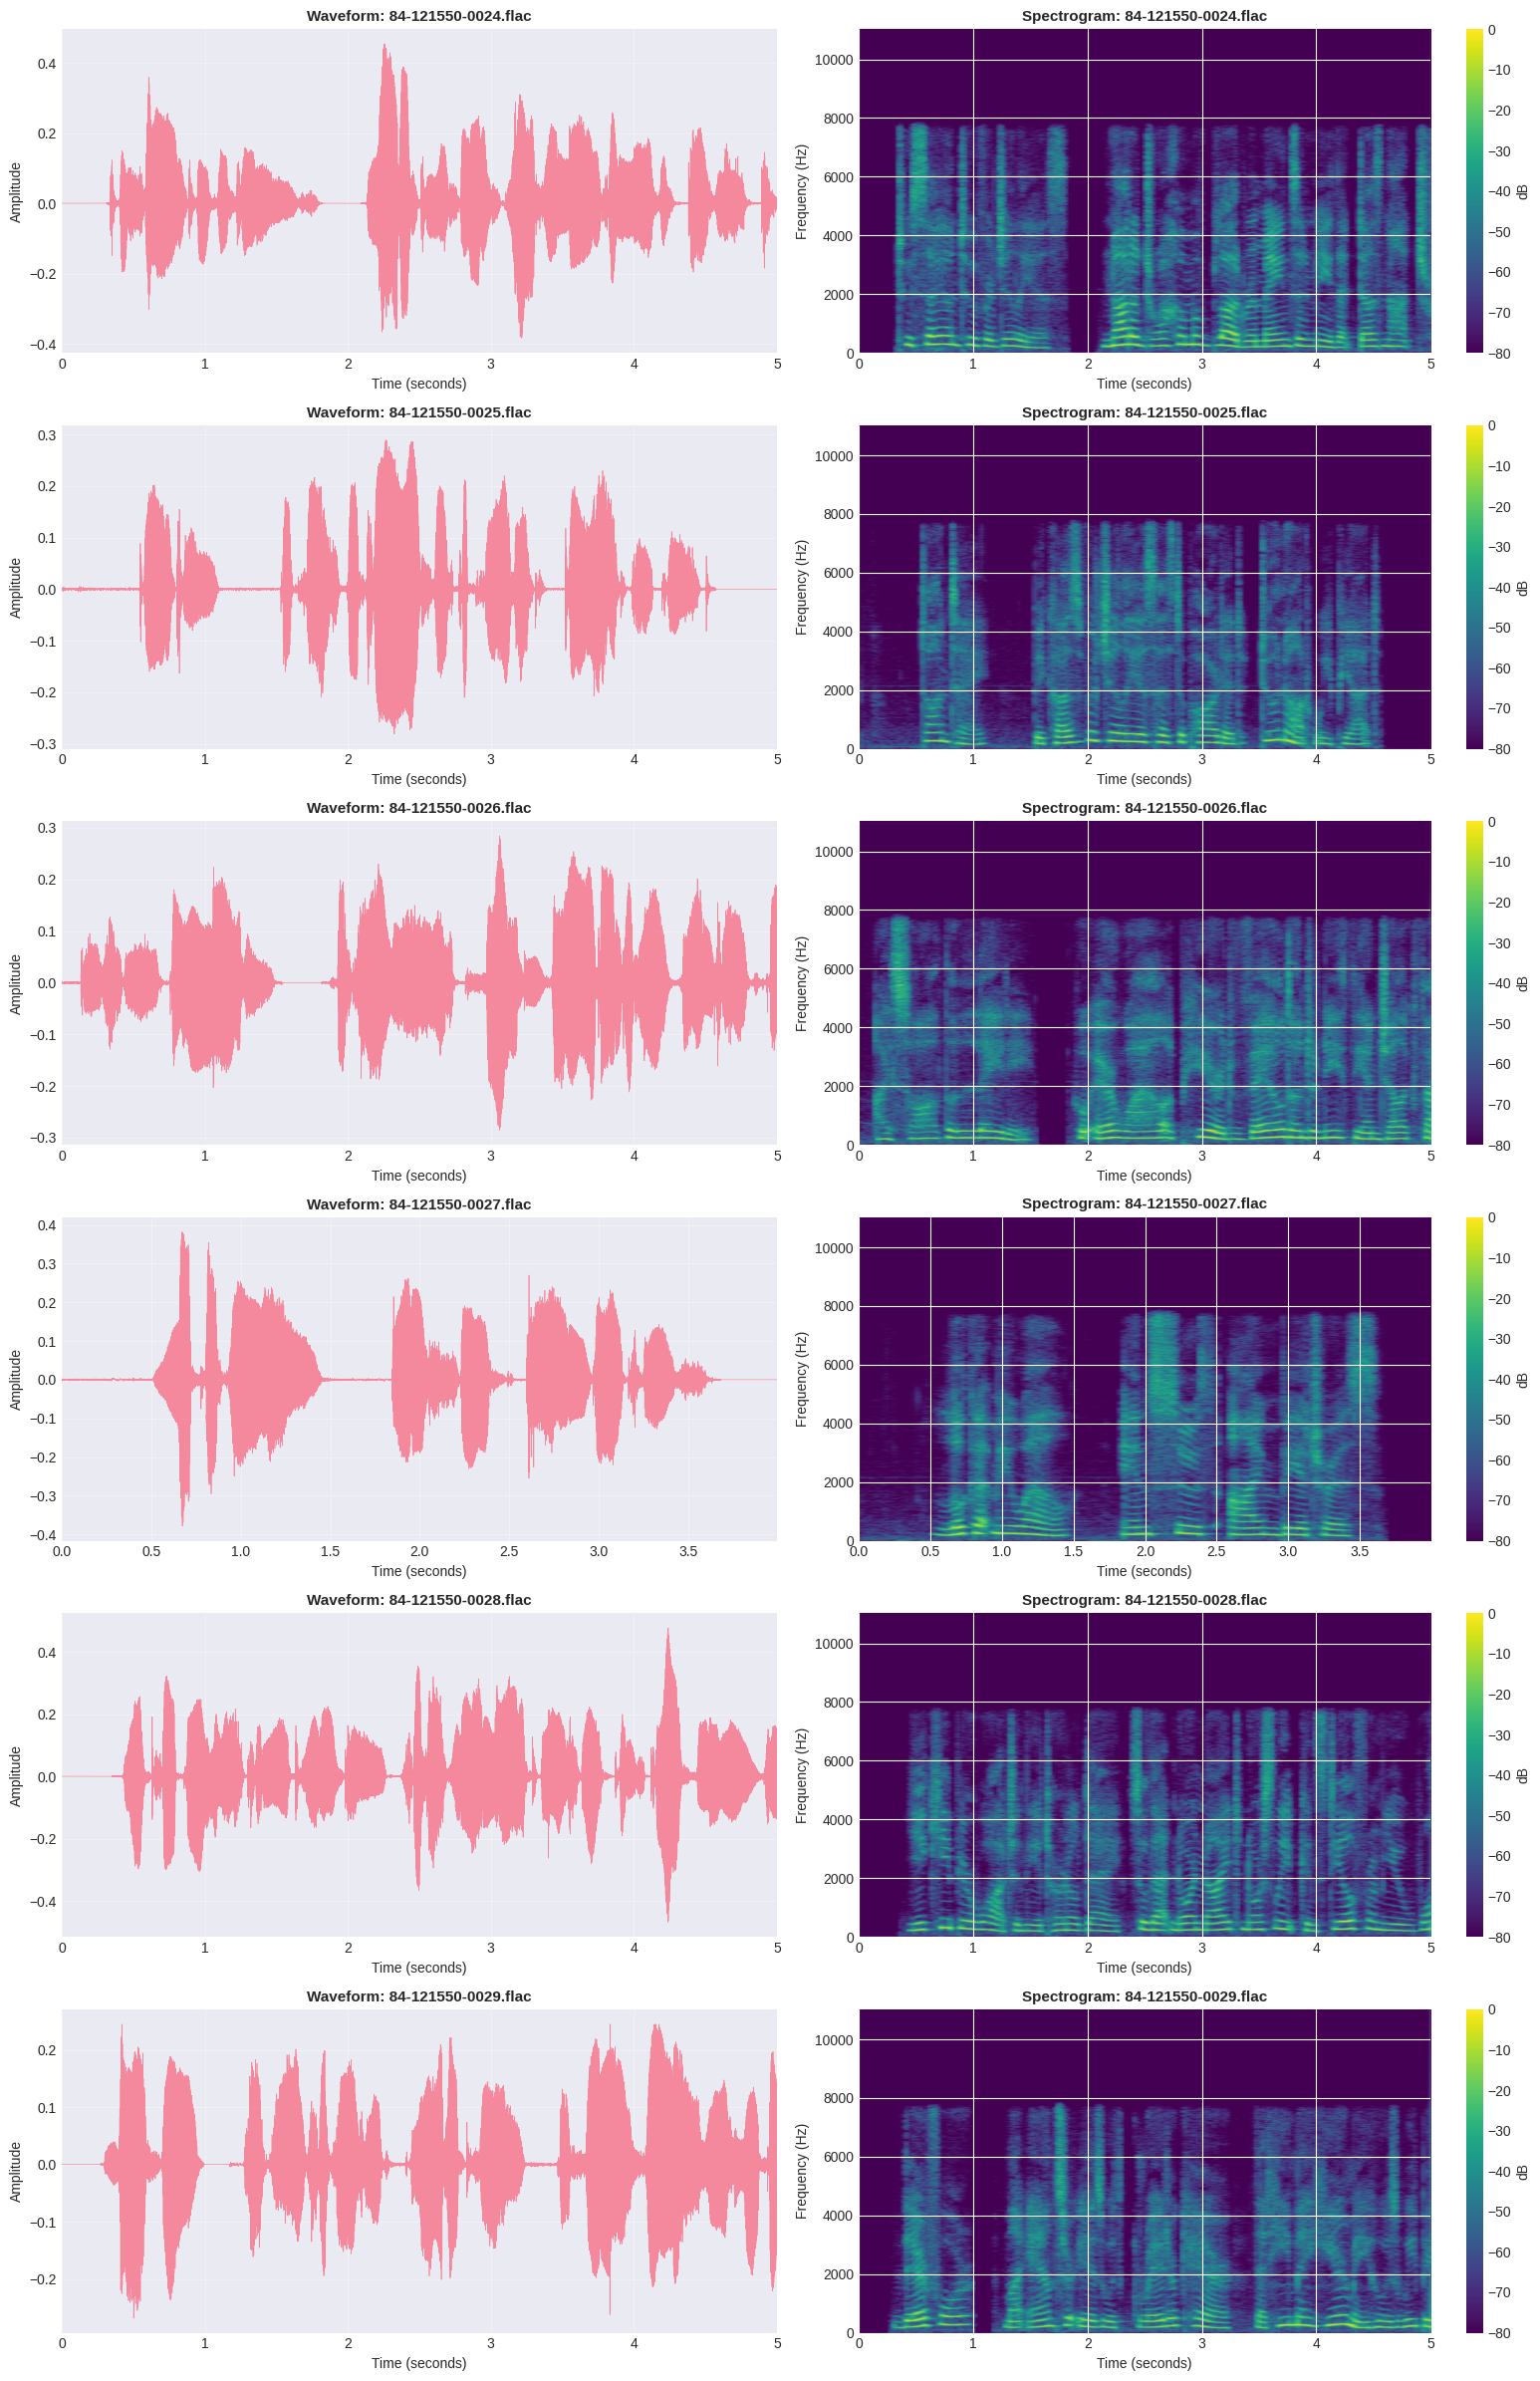


✅ Visualized 6 unknown speaker audio files
   Left: Waveforms (time-domain)
   Right: Spectrograms (time-frequency domain)


In [110]:
if len(unknown_speaker_files) > 0:
    print("\n" + "="*80)
    print("VISUALIZING UNKNOWN SPEAKER AUDIO")
    print("="*80)

    # Select a few sample files to visualize
    num_samples = min(6, len(unknown_speaker_files))
    sample_files = unknown_speaker_files[:num_samples]

    print(f"\n Visualizing {num_samples} unknown speaker audio files...")

    fig, axes = plt.subplots(num_samples, 2, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for idx, audio_path in enumerate(sample_files):
        try:

            audio, sr = librosa.load(audio_path, sr=22050, duration=5.0)

            time_axis = np.linspace(0, len(audio) / sr, len(audio))
            axes[idx, 0].plot(time_axis, audio, linewidth=0.5, alpha=0.8)
            axes[idx, 0].set_title(f'Waveform: {os.path.basename(audio_path)}',
                                  fontsize=11, fontweight='bold')
            axes[idx, 0].set_xlabel('Time (seconds)', fontsize=10)
            axes[idx, 0].set_ylabel('Amplitude', fontsize=10)
            axes[idx, 0].grid(alpha=0.3)
            axes[idx, 0].set_xlim([0, len(audio) / sr])

            D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
            im = axes[idx, 1].imshow(D, aspect='auto', origin='lower',
                                    extent=[0, len(audio) / sr, 0, sr/2],
                                    cmap='viridis', interpolation='bilinear')
            axes[idx, 1].set_title(f'Spectrogram: {os.path.basename(audio_path)}',
                                  fontsize=11, fontweight='bold')
            axes[idx, 1].set_xlabel('Time (seconds)', fontsize=10)
            axes[idx, 1].set_ylabel('Frequency (Hz)', fontsize=10)
            plt.colorbar(im, ax=axes[idx, 1], label='dB')

        except Exception as e:
            axes[idx, 0].text(0.5, 0.5, f'Error loading:\n{os.path.basename(audio_path)}',
                            ha='center', va='center', transform=axes[idx, 0].transAxes)
            axes[idx, 1].text(0.5, 0.5, f'Error loading:\n{os.path.basename(audio_path)}',
                            ha='center', va='center', transform=axes[idx, 1].transAxes)
            print(f"   ⚠️  Error loading {audio_path}: {e}")

    plt.tight_layout()
    plt.show()

    print(f"\n Visualized {num_samples} unknown speaker audio files")
    print(f"   Left: Waveforms (time-domain)")
    print(f"   Right: Spectrograms (time-frequency domain)")
else:
    print("\n⚠️  No unknown speaker files to visualize")


##  Step 7: EDA on Combined Dataset

Now let's perform EDA on the combined dataset (audio features.csv and the unknown speakers dataset).


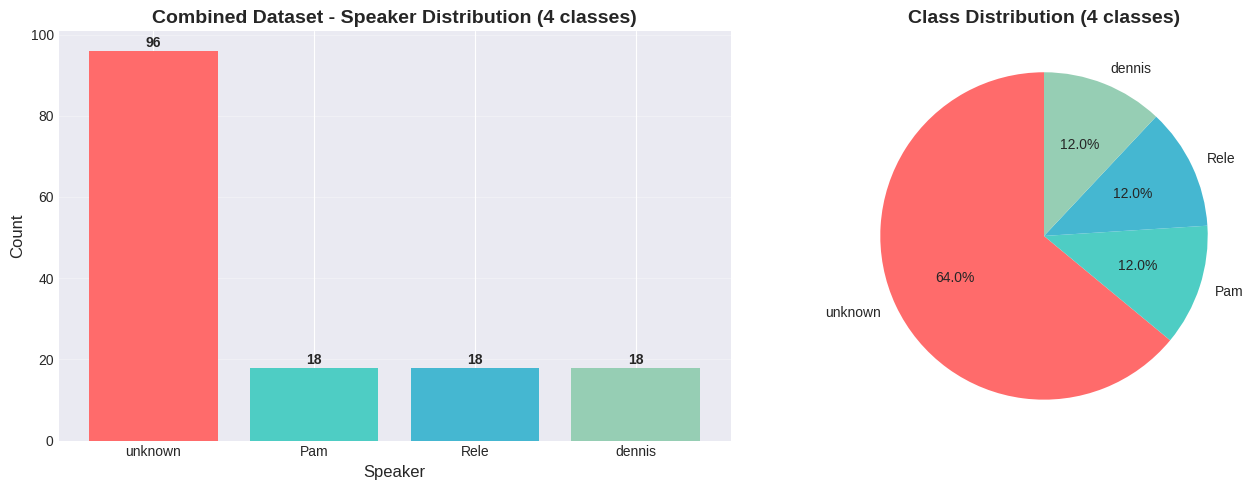


 Combined Dataset Summary:
   Total samples: 150
   Classes: 4
   Features: 91
   unknown: 96 samples (64.0%)
   Pam: 18 samples (12.0%)
   Rele: 18 samples (12.0%)
   dennis: 18 samples (12.0%)

  CLASS IMBALANCE ANALYSIS
  SEVERE CLASS IMBALANCE DETECTED!
   Largest class: 64.0%
   Smallest class: 12.0%
   Imbalance ratio: 5.3x


In [94]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

speaker_counts_all = df_all['speaker'].value_counts()
axes[0].bar(speaker_counts_all.index, speaker_counts_all.values,
           color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(speaker_counts_all)])
axes[0].set_title(f'Combined Dataset - Speaker Distribution ({num_classes} classes)',
                 fontsize=14, fontweight='bold')
axes[0].set_xlabel('Speaker', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(speaker_counts_all.values):
    axes[0].text(i, v + max(speaker_counts_all.values)*0.01, str(v),
                ha='center', fontweight='bold')

axes[1].pie(speaker_counts_all.values, labels=speaker_counts_all.index,
           autopct='%1.1f%%',
           colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(speaker_counts_all)],
           startangle=90)
axes[1].set_title(f'Class Distribution ({num_classes} classes)',
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n Combined Dataset Summary:")
print(f"   Total samples: {len(df_all)}")
print(f"   Classes: {num_classes}")
print(f"   Features: {len(feature_cols)}")
for speaker, count in speaker_counts_all.items():
    percentage = (count / len(df_all)) * 100
    print(f"   {speaker}: {count} samples ({percentage:.1f}%)")

print(f"\n" + "="*80)
print("  CLASS IMBALANCE ANALYSIS")
print("="*80)
max_class_pct = max([(count / len(df_all)) * 100 for count in speaker_counts_all.values])
min_class_pct = min([(count / len(df_all)) * 100 for count in speaker_counts_all.values])
imbalance_ratio = max_class_pct / min_class_pct if min_class_pct > 0 else float('inf')

if imbalance_ratio > 3:
    print(f"  SEVERE CLASS IMBALANCE DETECTED!")
    print(f"   Largest class: {max_class_pct:.1f}%")
    print(f"   Smallest class: {min_class_pct:.1f}%")
    print(f"   Imbalance ratio: {imbalance_ratio:.1f}x")

##  Step 8: Prepare Data for Training

Prepare the data by splitting into train/test sets, encoding labels, and scaling features.


In [93]:
print("\n" + "="*80)
print("STEP 8: PREPARING DATA FOR TRAINING")
print("="*80)

exclude_cols = ['file_id', 'speaker', 'audio_name', 'augmentation', 'audio_path']
feature_cols = [col for col in df_all.columns if col not in exclude_cols]
X = df_all[feature_cols].copy()
y = df_all['speaker'].copy()

X = X.fillna(X.median())

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n Dataset Information:")
print(f"   Total samples: {len(X)}")
print(f"   Features: {len(feature_cols)}")
print(f"   Classes: {label_encoder.classes_}")
print(f"   Class distribution:")
for cls in label_encoder.classes_:
    count = (y == cls).sum()
    print(f"      {cls}: {count} samples ({count/len(y)*100:.1f}%)")

print("\n Splitting data (file-based split - NO DATA LEAKAGE)...")
unique_files = df_all['audio_name'].unique()
file_speakers = df_all.groupby('audio_name')['speaker'].first()
print(f"   Unique audio files: {len(unique_files)}")


train_files, test_files = train_test_split(
    unique_files,
    test_size=0.3,
    random_state=42,
    stratify=[file_speakers[f] for f in unique_files]
)


train_mask = df_all['audio_name'].isin(train_files)
test_mask = df_all['audio_name'].isin(test_files)

X_train = X[train_mask].copy()
X_test = X[test_mask].copy()
y_train = y[train_mask].copy()
y_test = y[test_mask].copy()
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"\n Data Split:")
print(f"   Training: {len(X_train)} samples from {len(train_files)} files")
print(f"   Testing: {len(X_test)} samples from {len(test_files)} files")

train_file_set = set(df_all[train_mask]['audio_name'].unique())
test_file_set = set(df_all[test_mask]['audio_name'].unique())
overlap = train_file_set & test_file_set
if len(overlap) == 0:
    print(f"    No data leakage: 0 files overlap between train/test")
else:
    print(f"     WARNING: {len(overlap)} files in both train and test!")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"    Features scaled")

print(f"\n Handling class imbalance...")
try:
    from imblearn.over_sampling import SMOTE

    class_counts = pd.Series(y_train).value_counts()
    max_count = class_counts.max()
    min_count = class_counts.min()
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

    if imbalance_ratio > 2:
        print(f"   Applying SMOTE (imbalance ratio: {imbalance_ratio:.1f}x)...")
        # Use k_neighbors = min(5, min_count-1) to avoid errors
        k_neighbors = min(5, min_count - 1) if min_count > 1 else 1
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_train_scaled, y_train_encoded = smote.fit_resample(X_train_scaled, y_train_encoded)
        y_train = label_encoder.inverse_transform(y_train_encoded)

        print(f"    After SMOTE:")
        print(f"      Training samples: {len(X_train_scaled)}")
        print(f"      Class distribution:")
        for cls in label_encoder.classes_:
            count = (y_train == cls).sum()
            print(f"         {cls}: {count} samples")
    else:
        print(f"    Class distribution is balanced (ratio: {imbalance_ratio:.1f}x)")
        print(f"      Skipping SMOTE")
except ImportError:
    print(f"     imbalanced-learn not installed. Install with: pip install imbalanced-learn")
    print(f"   Will use class_weight='balanced' in models instead")
except Exception as e:
    print(f"     SMOTE failed: {e}")
    print(f"   Will use class_weight='balanced' in models instead")



STEP 8: PREPARING DATA FOR TRAINING

 Dataset Information:
   Total samples: 150
   Features: 91
   Classes: ['Pam' 'Rele' 'dennis' 'unknown']
   Class distribution:
      Pam: 18 samples (12.0%)
      Rele: 18 samples (12.0%)
      dennis: 18 samples (12.0%)
      unknown: 96 samples (64.0%)

 Splitting data (file-based split - NO DATA LEAKAGE)...
   Unique audio files: 18

 Data Split:
   Training: 100 samples from 12 files
   Testing: 50 samples from 6 files
    No data leakage: 0 files overlap between train/test
    Features scaled

 Handling class imbalance...
   Applying SMOTE (imbalance ratio: 7.1x)...
    After SMOTE:
      Training samples: 256
      Class distribution:
         Pam: 64 samples
         Rele: 64 samples
         dennis: 64 samples
         unknown: 64 samples


##  Step 9: Train Multiple Models

Train and compare multiple models: Logistic Regression, Random Forest, SVM, Neural Network (MLP), and XGBoost.


In [92]:
print("\n" + "="*80)
print("STEP 9: TRAINING MULTIPLE MODELS")
print("="*80)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = dict(zip(np.unique(y_train_encoded), class_weights))

print(f"\n Class weights for balancing: {dict(zip(label_encoder.classes_, class_weights))}")


models = {}
models_config = {}

print(f"\n{'='*80}")
print("  Training Logistic Regression...")
print(f"{'='*80}")
C_values = [0.01, 0.1, 1.0, 10.0]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_score_lr = 0
best_C = 0.1

for C in C_values:
    model = LogisticRegression(
        C=C, max_iter=1000, random_state=42,
        multi_class='multinomial', solver='lbfgs',
        class_weight='balanced'
    )
    scores = cross_val_score(model, X_train_scaled, y_train_encoded,
                            cv=cv, scoring='f1_weighted', n_jobs=-1)
    mean_score = scores.mean()
    if mean_score > best_score_lr:
        best_score_lr = mean_score
        best_C = C

lr_model = LogisticRegression(
    C=best_C, max_iter=1000, random_state=42,
    multi_class='multinomial', solver='lbfgs',
    class_weight='balanced'
)
lr_model = CalibratedClassifierCV(lr_model, method='isotonic', cv=5)
lr_model.fit(X_train_scaled, y_train_encoded)
models['Logistic Regression'] = lr_model
models_config['Logistic Regression'] = {'C': best_C}
print(f" Logistic Regression trained (C={best_C}, CV F1={best_score_lr:.4f})")

print(f"\n{'='*80}")
print("  Training Random Forest...")
print(f"{'='*80}")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train_encoded)
models['Random Forest'] = rf_model
models_config['Random Forest'] = {'n_estimators': 100, 'max_depth': 20}
print(f" Random Forest trained")

print(f"\n{'='*80}")
print("  Training Support Vector Machine (SVM)...")
print(f"{'='*80}")
svm_model = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42
)
svm_model.fit(X_train_scaled, y_train_encoded)
models['SVM'] = svm_model
models_config['SVM'] = {'C': 1.0, 'kernel': 'rbf'}
print(f" SVM trained")


print(f"\n{'='*80}")
print("  Training Neural Network (MLP)...")
print(f"{'='*80}")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
mlp_model.fit(X_train_scaled, y_train_encoded)
models['Neural Network (MLP)'] = mlp_model
models_config['Neural Network (MLP)'] = {'hidden_layers': (100, 50)}
print(f" Neural Network (MLP) trained")


if XGBOOST_AVAILABLE:
    print(f"\n{'='*80}")
    print("5️  Training XGBoost...")
    print(f"{'='*80}")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    )
    xgb_model.fit(X_train_scaled, y_train_encoded)
    models['XGBoost'] = xgb_model
    models_config['XGBoost'] = {'n_estimators': 100, 'max_depth': 6}
    print(f" XGBoost trained")
else:
    print(f"\n  Skipping XGBoost (not installed)")

print(f"\n{'='*80}")
print(f" ALL MODELS TRAINED!")
print(f"{'='*80}")
print(f"   Trained {len(models)} models: {', '.join(models.keys())}")



STEP 9: TRAINING MULTIPLE MODELS

 Class weights for balancing: {'Pam': np.float64(1.0), 'Rele': np.float64(1.0), 'dennis': np.float64(1.0), 'unknown': np.float64(1.0)}

  Training Logistic Regression...
 Logistic Regression trained (C=0.01, CV F1=1.0000)

  Training Random Forest...
 Random Forest trained

  Training Support Vector Machine (SVM)...
 SVM trained

  Training Neural Network (MLP)...
 Neural Network (MLP) trained

5️  Training XGBoost...
 XGBoost trained

 ALL MODELS TRAINED!
   Trained 5 models: Logistic Regression, Random Forest, SVM, Neural Network (MLP), XGBoost


##  Step 10: Model Comparison and Evaluation

Compare all trained models and select the best one based on F1-score.



STEP 10: MODEL COMPARISON AND EVALUATION

EVALUATING ALL MODELS

 Evaluating Logistic Regression...
   Accuracy:  0.9200 (92.00%)
   Precision: 1.0000 (100.00%)
   Recall:    0.9200 (92.00%)
   F1-Score:  0.9486 (94.86%)

 Evaluating Random Forest...
   Accuracy:  0.8200 (82.00%)
   Precision: 0.8200 (82.00%)
   Recall:    0.8200 (82.00%)
   F1-Score:  0.8200 (82.00%)

 Evaluating SVM...
   Accuracy:  0.8200 (82.00%)
   Precision: 0.8200 (82.00%)
   Recall:    0.8200 (82.00%)
   F1-Score:  0.8200 (82.00%)

 Evaluating Neural Network (MLP)...
   Accuracy:  0.9600 (96.00%)
   Precision: 0.9800 (98.00%)
   Recall:    0.9600 (96.00%)
   F1-Score:  0.9698 (96.98%)

 Evaluating XGBoost...
   Accuracy:  0.8200 (82.00%)
   Precision: 0.9175 (91.75%)
   Recall:    0.8200 (82.00%)
   F1-Score:  0.8482 (84.82%)

MODEL COMPARISON SUMMARY

               Model  Accuracy  Precision  Recall  F1-Score
Neural Network (MLP)      0.96     0.9800    0.96  0.969841
 Logistic Regression      0.92     1.000

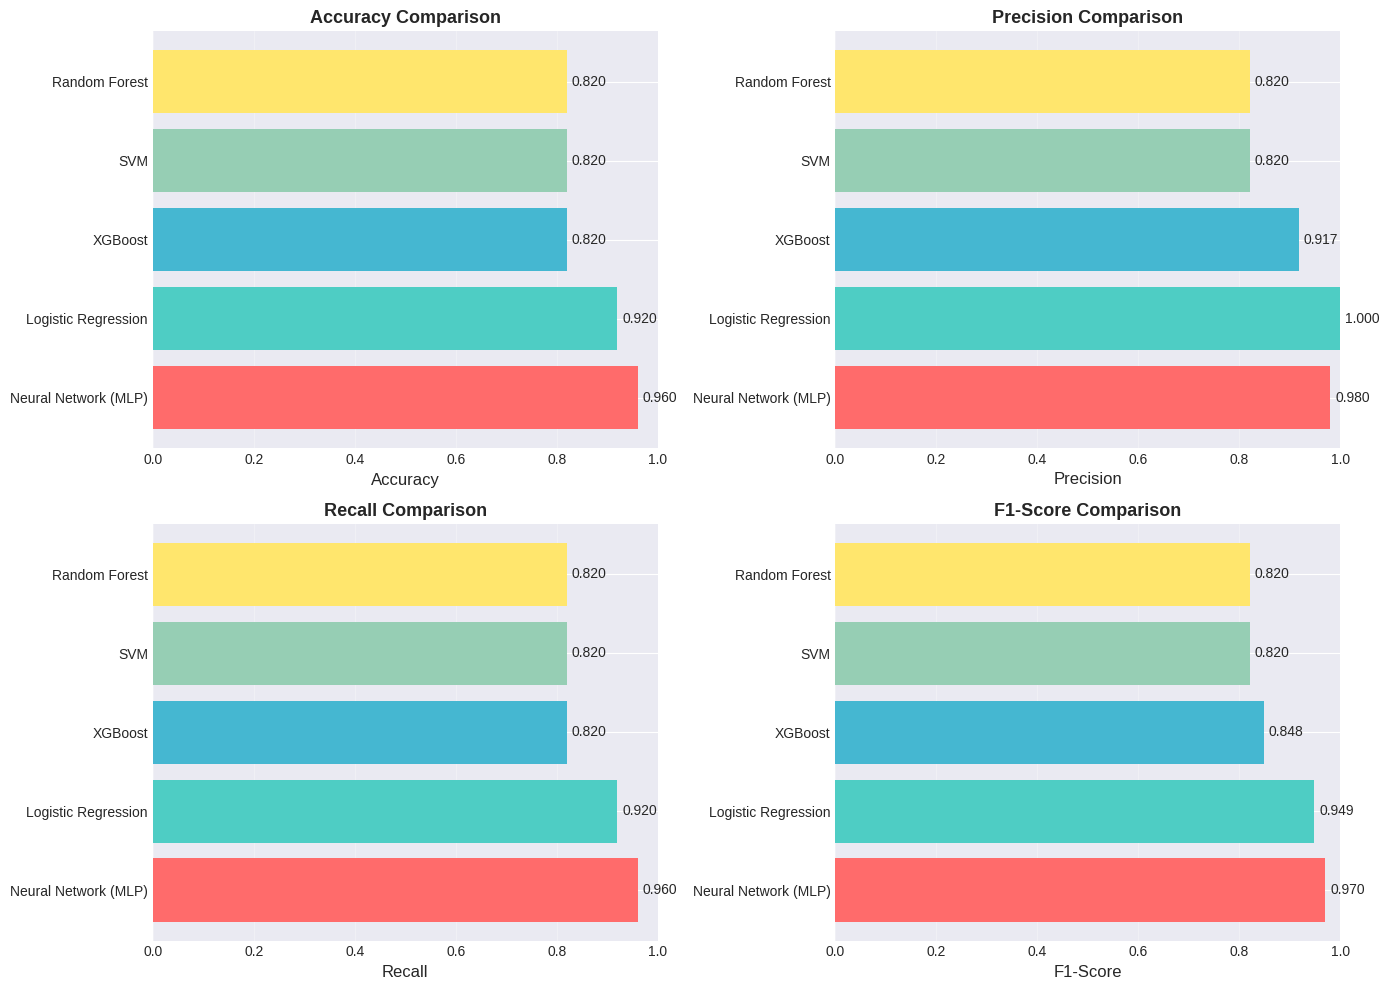


 BEST MODEL: Neural Network (MLP)
   F1-Score: 0.9698
   Accuracy: 0.9600


In [91]:
print("\n" + "="*80)
print("STEP 10: MODEL COMPARISON AND EVALUATION")
print("="*80)

model_results = {}

print(f"\n{'='*80}")
print("EVALUATING ALL MODELS")
print(f"{'='*80}")

for model_name, model in models.items():
    print(f"\n Evaluating {model_name}...")

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)

    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)

    f1_per_class = f1_score(y_test_encoded, y_pred, average=None, zero_division=0)

    model_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1,
        'f1_per_class': f1_per_class,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

print(f"\n{'='*80}")
print("MODEL COMPARISON SUMMARY")
print(f"{'='*80}")

comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [r['accuracy'] for r in model_results.values()],
    'Precision': [r['precision'] for r in model_results.values()],
    'Recall': [r['recall'] for r in model_results.values()],
    'F1-Score': [r['f1_weighted'] for r in model_results.values()]
}).sort_values('F1-Score', ascending=False)

print("\n" + comparison_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFE66D'][:len(values)]
    bars = ax.barh(comparison_df['Model'], values, color=colors)
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.grid(axis='x', alpha=0.3)

    for i, (bar, val) in enumerate(zip(bars, values)):
        ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

best_model_name = comparison_df.iloc[0]['Model']
best_model = model_results[best_model_name]['model']
y_pred = model_results[best_model_name]['predictions']
y_pred_proba = model_results[best_model_name]['probabilities']

print(f"\n{'='*80}")
print(f" BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"   F1-Score: {model_results[best_model_name]['f1_weighted']:.4f}")
print(f"   Accuracy: {model_results[best_model_name]['accuracy']:.4f}")


lr_model = best_model
accuracy = model_results[best_model_name]['accuracy']
precision = model_results[best_model_name]['precision']
recall = model_results[best_model_name]['recall']
f1 = model_results[best_model_name]['f1_weighted']


##  Step 11: Detailed Evaluation of Best Model

Evaluate the best model's performance with comprehensive metrics and visualizations.


In [90]:
print("\n" + "="*80)
print(f"STEP 11: DETAILED EVALUATION - {best_model_name}")
print("="*80)


accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)

loss = log_loss(y_test_encoded, y_pred_proba, labels=np.arange(num_classes))

print("\n" + "="*80)
print("FINAL MODEL PERFORMANCE")
print("="*80)
print(f"Classes: {num_classes} ({', '.join(label_encoder.classes_)})")
print(f"\nOverall Metrics:")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"  Log Loss:  {loss:.4f}")

print("\n" + "-"*80)
print("CLASSIFICATION REPORT")
print("-"*80)
print(classification_report(y_test_encoded, y_pred,
                            target_names=label_encoder.classes_,
                            zero_division=0))


STEP 11: DETAILED EVALUATION - Neural Network (MLP)

FINAL MODEL PERFORMANCE
Classes: 4 (Pam, Rele, dennis, unknown)

Overall Metrics:
  Accuracy:  0.9600 (96.00%)
  Precision: 0.9800 (98.00%)
  Recall:    0.9600 (96.00%)
  F1-Score:  0.9698 (96.98%)
  Log Loss:  0.5560

--------------------------------------------------------------------------------
CLASSIFICATION REPORT
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         Pam       0.00      0.00      0.00         0
        Rele       1.00      1.00      1.00         9
      dennis       0.89      0.89      0.89         9
     unknown       1.00      0.97      0.98        32

    accuracy                           0.96        50
   macro avg       0.72      0.71      0.72        50
weighted avg       0.98      0.96      0.97        50



In [89]:
if 'unknown' in label_encoder.classes_:
    print("\n" + "-"*80)
    print("UNKNOWN SPEAKER DETECTION PERFORMANCE")
    print("-"*80)

    unknown_mask = y_test == 'unknown'
    unknown_idx = label_encoder.transform(['unknown'])[0]

    if unknown_mask.sum() > 0:

        unknown_correct = (y_pred[unknown_mask] == unknown_idx).sum()
        unknown_total = unknown_mask.sum()
        unknown_recall = unknown_correct / unknown_total


        known_mask = y_test != 'unknown'
        false_unknown = (y_pred[known_mask] == unknown_idx).sum()
        known_total = known_mask.sum()
        false_alarm_rate = false_unknown / known_total

        print(f"Unknown Speaker Recall: {unknown_recall:.2%} ({unknown_correct}/{unknown_total})")
        print(f"   Model correctly identifies {unknown_recall:.0%} of unknown speakers")
        print(f"\nFalse Alarm Rate: {false_alarm_rate:.2%} ({false_unknown}/{known_total})")
        print(f"   Model incorrectly rejects {false_alarm_rate:.0%} of known speakers")

    else:
        print("No unknown speakers in the test set")


--------------------------------------------------------------------------------
UNKNOWN SPEAKER DETECTION PERFORMANCE
--------------------------------------------------------------------------------
Unknown Speaker Recall: 96.88% (31/32)
   Model correctly identifies 97% of unknown speakers

False Alarm Rate: 0.00% (0/18)
   Model incorrectly rejects 0% of known speakers



--------------------------------------------------------------------------------
CONFUSION MATRIX
--------------------------------------------------------------------------------


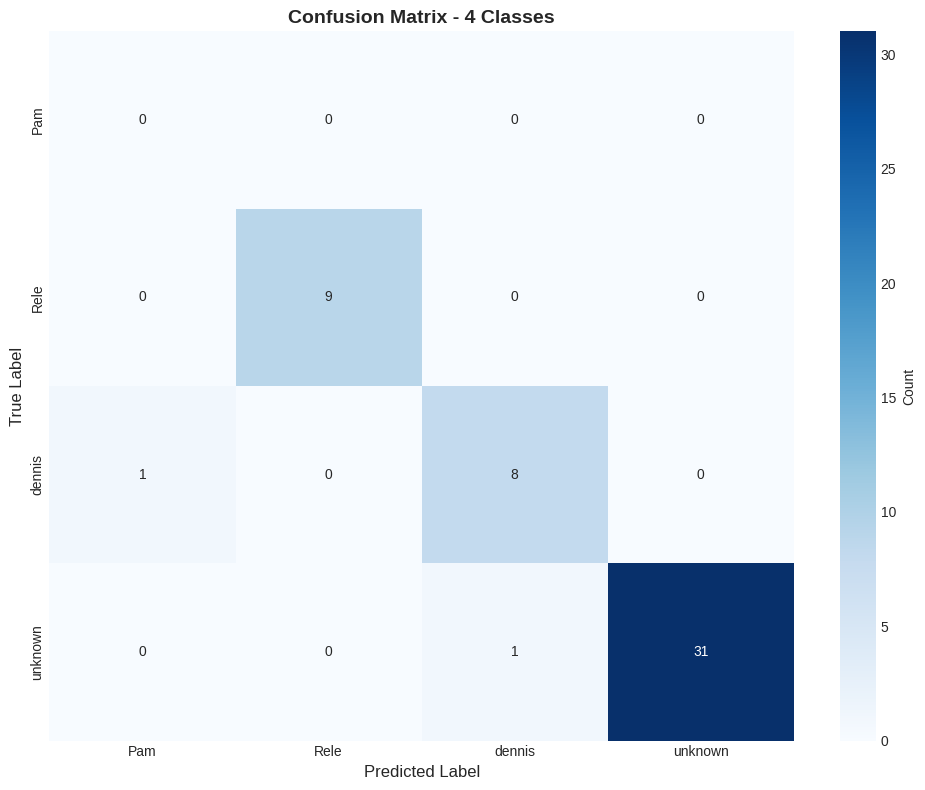

Confusion matrix shows:
  - Diagonal: Correct predictions
  - Off-diagonal: Misclassifications


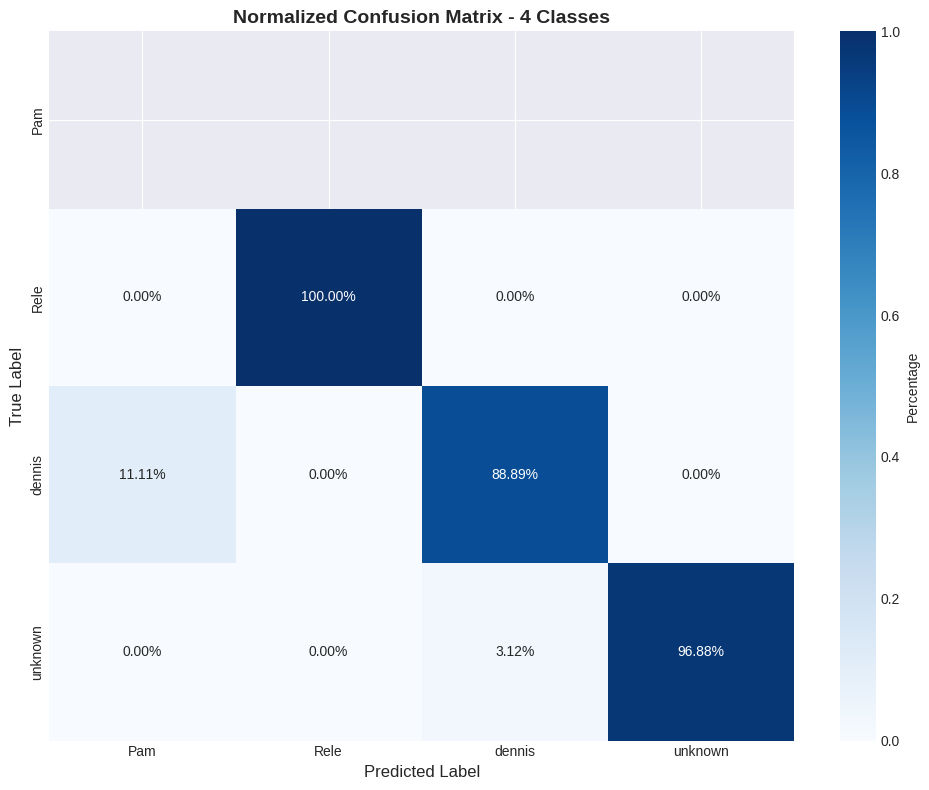

In [73]:
# Confusion Matrix
print("\n" + "-"*80)
print("CONFUSION MATRIX")
print("-"*80)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {num_classes} Classes', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("Confusion matrix shows:")
print("  - Diagonal: Correct predictions")
print("  - Off-diagonal: Misclassifications")

# Normalized confusion matrix
plt.figure(figsize=(10, 8))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Percentage'})
plt.title(f'Normalized Confusion Matrix - {num_classes} Classes',
         fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()


### 11.1 Per-Class Performance Visualization


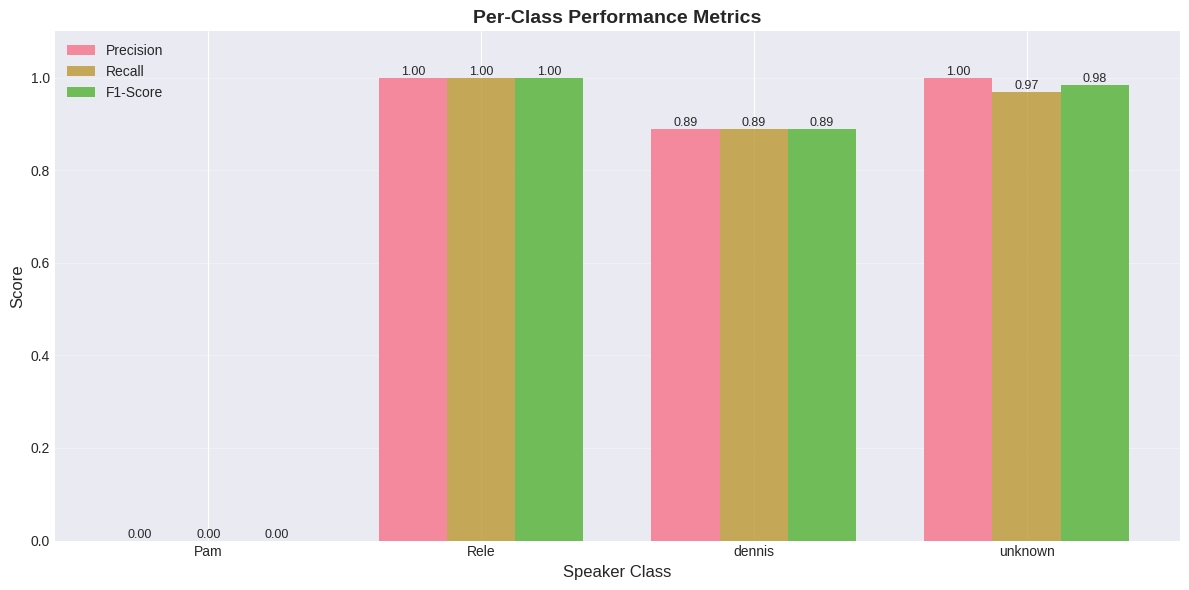

In [87]:
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    y_test_encoded, y_pred, average=None, zero_division=0, labels=range(len(label_encoder.classes_))
)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(label_encoder.classes_))
width = 0.25

bars1 = ax.bar(x - width, precision_per_class, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, recall_per_class, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Speaker Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder.classes_)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}',
               ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


##  Step 12: Save Improved Models

Save all model components for later use.


In [86]:
print("\n" + "="*80)
print("STEP 12: SAVING IMPROVED MODELS")
print("="*80)


model_dir = 'models_improved'
os.makedirs(model_dir, exist_ok=True)


files_to_save = {
    'voiceprint_model.pkl': lr_model,
    'voiceprint_scaler.pkl': scaler,
    'voiceprint_label_encoder.pkl': label_encoder,
    'voiceprint_feature_cols.pkl': feature_cols
}

print(f"\nSaving to directory: {model_dir}/")
print("-" * 60)
for filename, obj in files_to_save.items():
    filepath = os.path.join(model_dir, filename)
    joblib.dump(obj, filepath)
    size_kb = os.path.getsize(filepath) / 1024
    print(f" {filename:40s} ({size_kb:6.2f} KB)")

# Verify all files exist
print("\n" + "-"*60)
print("VERIFICATION")
print("-"*60)
all_saved = True
for filename in files_to_save.keys():
    filepath = os.path.join(model_dir, filename)
    if os.path.exists(filepath):
        print(f" {filename}")
    else:
        print(f" {filename} - MISSING!")
        all_saved = False

if all_saved:
    print("\n" + "="*80)
    print(" SUCCESS! ALL MODELS SAVED")
    print("="*80)
    print(f"\nYour improved models are ready in: {model_dir}/")
    print(f"\nModel features:")
    print(f"  • {num_classes} classes: {', '.join(label_encoder.classes_)}")
    print(f"  • Accuracy: {accuracy:.2%}")
    print(f"  • Calibrated probabilities")
    if 'unknown' in label_encoder.classes_:
        print(f"  • Unknown speaker detection enabled ")
    else:
        print(f"  • Unknown speaker detection NOT enabled ")
else:
    print("\n SOME FILES FAILED TO SAVE!")



STEP 12: SAVING IMPROVED MODELS

Saving to directory: models_improved/
------------------------------------------------------------
 voiceprint_model.pkl                     (346.92 KB)
 voiceprint_scaler.pkl                    (  4.28 KB)
 voiceprint_label_encoder.pkl             (  0.49 KB)
 voiceprint_feature_cols.pkl              (  1.34 KB)

------------------------------------------------------------
VERIFICATION
------------------------------------------------------------
 voiceprint_model.pkl
 voiceprint_scaler.pkl
 voiceprint_label_encoder.pkl
 voiceprint_feature_cols.pkl

 SUCCESS! ALL MODELS SAVED

Your improved models are ready in: models_improved/

Model features:
  • 4 classes: Pam, Rele, dennis, unknown
  • Accuracy: 96.00%
  • Calibrated probabilities
  • Unknown speaker detection enabled 


##  Download Files (Google Colab)

Download model files


In [85]:
print("\n" + "="*80)
print("STEP 16: DOWNLOAD MODEL FILES")
print("="*80)

try:
    from google.colab import files

    print("\n Preparing files for download...")

    model_files = [
        'voiceprint_model.pkl',
        'voiceprint_scaler.pkl',
        'voiceprint_label_encoder.pkl',
        'voiceprint_feature_cols.pkl'
    ]

    for filename in model_files:
        filepath = os.path.join(model_dir, filename)
        if os.path.exists(filepath):
            files.download(filepath)
            print(f" Downloaded: {filename}")

    csv_files = ['unknown_features.csv', 'audio_features.csv']
    for csv_file in csv_files:
        if os.path.exists(csv_file):
            files.download(csv_file)
            print(f" Downloaded: {csv_file}")

    print("\n All files downloaded!")

except ImportError:
    print("\ Not running in Google Colab")
    print(f"   Models saved in: {os.path.abspath(model_dir)}/")
except Exception as e:
    print(f"\n  Download error: {e}")
    print(f"   Models are saved in: {os.path.abspath(model_dir)}/")



STEP 16: DOWNLOAD MODEL FILES

 Preparing files for download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: voiceprint_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: voiceprint_scaler.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: voiceprint_label_encoder.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: voiceprint_feature_cols.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Downloaded: unknown_features.csv

 All files downloaded!


##  Final Summary

Summary of the complete workflow and results.


In [83]:
print("\n" + "="*80)
print(" FINAL SUMMARY")
print("="*80)

summary = f"""
 MODEL TRAINING COMPLETE!

Performance Summary:
   • Total samples trained: {len(df_all)}
   • Number of classes: {num_classes}
   • Classes: {', '.join(label_encoder.classes_)}
   • Test accuracy: {accuracy:.2%}
   • F1-Score: {f1:.2%}

 Key Improvements:
   • {"Unknown speaker detection enabled" if num_classes==4 else "⚠️  Unknown speaker detection NOT enabled (no unknown files provided)"}
   •  Probability calibration for better confidence scores
   •  File-based splitting prevents data leakage
   •  Cross-validated hyperparameters (C = {best_C})

 Saved Files:
   • Model: {model_dir}/voiceprint_model.pkl
   • Scaler: {model_dir}/voiceprint_scaler.pkl
   • Encoder: {model_dir}/voiceprint_label_encoder.pkl
   • Features: {model_dir}/voiceprint_feature_cols.pkl
"""

print(summary)



 FINAL SUMMARY

 MODEL TRAINING COMPLETE!

Performance Summary:
   • Total samples trained: 150
   • Number of classes: 4
   • Classes: Pam, Rele, dennis, unknown
   • Test accuracy: 96.00%
   • F1-Score: 96.98%

 Key Improvements:
   • Unknown speaker detection enabled
   •  Probability calibration for better confidence scores
   •  File-based splitting prevents data leakage
   •  Cross-validated hyperparameters (C = 0.01)

 Saved Files:
   • Model: models_improved/voiceprint_model.pkl
   • Scaler: models_improved/voiceprint_scaler.pkl
   • Encoder: models_improved/voiceprint_label_encoder.pkl
   • Features: models_improved/voiceprint_feature_cols.pkl

